<a href="https://colab.research.google.com/github/sriracha7/neuro-ratings_yelp/blob/main/NeuroRatings_Project_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# @title Install dependencies
!pip install pandas --quiet
!pip install tqdm --quiet
!pip install gensim --quiet
!pip install torch --quiet


In [ ]:
# @title Importing Libraries

# mounting embedding models
from google.colab import drive
drive.mount('/content/drive')
w2v_path = '/content/drive/My Drive/NMA Project/Word Embeddings/GoogleNews-vectors-negative300-SLIM.bin.gz'
glove_path = '/content/drive/My Drive/NMA Project/Word Embeddings/glove.6B.100d.txt'

# matrices and plotting:
import numpy as np
import matplotlib.pyplot as plt

# pytorch:
import torch
import torch.nn as nn
from torch.nn import MaxPool1d
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset

# confusion matrix from sklearn
from sklearn.metrics import confusion_matrix

# to get some idea of how long stuff will take to complete:
import time

# to see how unbalanced the data is:
from collections import Counter

# pre-proccesing
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from sklearn.model_selection import train_test_split
import string
import re
import gensim
import pandas as pd
from torch.nn.functional import one_hot

# word embeddings
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

# model
from tqdm import tqdm

# ignore warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='huggingface_hub')
from sklearn.exceptions import UndefinedMetricWarning
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# @title Figure settings
import logging
logging.getLogger('matplotlib.font_manager').disabled = True

import ipywidgets as widgets #interactive display

%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/content-creation/main/nma.mplstyle")

In [ ]:
# @title Set device (GPU or CPU). Execute `set_device()`
# inform the user if the notebook uses GPU or CPU.

def set_device():
  """
  Set the device. CUDA if available, CPU otherwise

  Args:
    None

  Returns:
    Nothing
  """
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("GPU is not enabled in this notebook. \n"
          "If you want to enable it, in the menu under `Runtime` -> \n"
          "`Hardware accelerator.` and select `GPU` from the dropdown menu")
  else:
    print("GPU is enabled in this notebook. \n"
          "If you want to disable it, in the menu under `Runtime` -> \n"
          "`Hardware accelerator.` and select `None` from the dropdown menu")

  return device

device = set_device()

GPU is enabled in this notebook. 
If you want to disable it, in the menu under `Runtime` -> 
`Hardware accelerator.` and select `None` from the dropdown menu


In [ ]:
# @title Set random seed functions. Execute set_seed(seed="#")
# @markdown Executing `set_seed(seed=seed)` you are setting the seed

# For DL its critical to set the random seed so that students can have a
# baseline to compare their results to expected results.
# Read more here: https://pytorch.org/docs/stable/notes/randomness.html

# Call `set_seed` function in the exercises to ensure reproducibility.
import random
import torch

def set_seed(seed=None, seed_torch=True):
  """
  Function that controls randomness. NumPy and random modules must be imported.

  Args:
    seed : Integer
      A non-negative integer that defines the random state. Default is `None`.
    seed_torch : Boolean
      If `True` sets the random seed for pytorch tensors, so pytorch module
      must be imported. Default is `True`.

  Returns:
    Nothing.
  """
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')


# In case that `DataLoader` is used
def seed_worker(worker_id):
  """
  DataLoader will reseed workers following randomness in
  multi-process data loading algorithm.

  Args:
    worker_id: integer
      ID of subprocess to seed. 0 means that
      the data will be loaded in the main process
      Refer: https://pytorch.org/docs/stable/data.html#data-loading-randomness for more details

  Returns:
    Nothing
  """
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

In [ ]:
# @title Set Dataframe
import pandas as pd
df = pd.read_parquet("hf://datasets/hienbm/Yelp_Restaurant_CA_2021/data/yelp_restaurant_CA_2021-00000-of-00001.parquet")
df = df.drop(columns=["user_id", "review_id","business_id", "date","name","address", "city", "state", "postal_code", "latitude", "longitude"])

# below is a default message for HF but the dataset is public so an authentication token is not necessary

In [ ]:
df

,review_stars,text,categories
0,2.0,2 things to know about Kyle's Kitchen if you o...,"Burgers, Ice Cream & Frozen Yogurt, American (..."
1,5.0,Very fresh and sizable portion with great tast...,"Restaurants, Asian Fusion, Food, Poke, Hawaiia..."
2,4.0,We were in Goleta area during COVID times. Ri...,"Restaurants, Asian Fusion, Food, Poke, Hawaiia..."
3,5.0,This is the greatest spot in the whole world. ...,"Event Planning & Services, Latin American, Cat..."
4,5.0,"This is a favorite spot of mine, and is unlike...","Korean, Restaurants, American (New), Mexican, ..."
...,...,...,...
18395,5.0,My dad and I decided to take a day trip to San...,"Coffee Roasteries, Acai Bowls, Food, Coffee & ..."
18396,5.0,Great pizza & amazin salads. Coctails were imp...,"Restaurants, Italian, Pizza"
18397,5.0,"Love the salsa and atmosphere, always nice to ...","Nightlife, Arts & Entertainment, Restaurants, ..."
18398,5.0,Always happy with their to go dinners. Really ...,"Food, Beer, Wine & Spirits, Specialty Food, De..."


In [ ]:
df["review_stars"].value_counts()

,count
review_stars,
5.0,10713
4.0,2786
1.0,2197
3.0,1443
2.0,1261


In [ ]:
df["review_stars"].describe()

,review_stars
count,18400.000000
mean,4.008533
std,1.417547
min,1.000000
25%,3.000000
50%,5.000000
75%,5.000000
max,5.000000


We noticed that within our dataset, the sampling sizes of each of the star-ratings (e.g. 1, 2, 3, 4, 5) were very unbalanced with approximately 58% of all the reviews being 5-stars. This raises issues as it could influence the model to rate too many of the reviews as 5-stars. To address this, we've employed random oversampling where we will duplicate reviews from the star-rating categories with lower frequencies in order to balance the data.

# Pre-Processing

We need to pre-process our reviews so they are in the simplest form they can be while still being interpretable by our networks.

In [ ]:
# @title Random Oversampling
df = pd.concat([df,df[df["review_stars"]==1.0]], ignore_index=True)
df = pd.concat([df,df[df["review_stars"]==1.0]], ignore_index=True)
df = pd.concat([df,df[df["review_stars"]==1.0].head(n=1925)], ignore_index=True)

df = pd.concat([df,df[df["review_stars"]==2.0]], ignore_index=True)
df = pd.concat([df,df[df["review_stars"]==2.0]], ignore_index=True)
df = pd.concat([df,df[df["review_stars"]==2.0]], ignore_index=True)
df = pd.concat([df,df[df["review_stars"]==2.0].head(n=625)], ignore_index=True)

df = pd.concat([df,df[df["review_stars"]==3.0]], ignore_index=True)
df = pd.concat([df,df[df["review_stars"]==3.0]], ignore_index=True)
df = pd.concat([df,df[df["review_stars"]==3.0].head(n=4941)], ignore_index=True)

df = pd.concat([df,df[df["review_stars"]==4.0]], ignore_index=True)
df = pd.concat([df,df[df["review_stars"]==4.0].head(n=5141)], ignore_index=True)


In [ ]:
df["review_stars"].value_counts()

,count
review_stars,
2.0,10713
5.0,10713
4.0,10713
1.0,10713
3.0,10713


In [ ]:
# @title Tokenization, Punctuation Removal, & Lower Case Conversion
nltk.download('punkt')

def tok_PR_LCC(text):
    text = re.sub(r'\d+', '', text)
    tokens = word_tokenize(text)  # tokenization
    tokens_cleaned = [token.lower() for token in tokens if token.isalnum()]  #  punctuation removal and lower case conversion
    return tokens_cleaned

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
df_encoded = pd.get_dummies(df, columns=['review_stars'])
df_encoded[df_encoded.columns[2:]] = df_encoded[df_encoded.columns[2:]].apply(lambda x: x.astype(int))
df_encoded['text'] = df_encoded['text'].apply(lambda x: tok_PR_LCC(x))
df_encoded

,text,categories,review_stars_1.0,review_stars_2.0,review_stars_3.0,review_stars_4.0,review_stars_5.0
0,"[things, to, know, about, kyle, kitchen, if, y...","Burgers, Ice Cream & Frozen Yogurt, American (...",0,1,0,0,0
1,"[very, fresh, and, sizable, portion, with, gre...","Restaurants, Asian Fusion, Food, Poke, Hawaiia...",0,0,0,0,1
2,"[we, were, in, goleta, area, during, covid, ti...","Restaurants, Asian Fusion, Food, Poke, Hawaiia...",0,0,0,1,0
3,"[this, is, the, greatest, spot, in, the, whole...","Event Planning & Services, Latin American, Cat...",0,0,0,0,1
4,"[this, is, a, favorite, spot, of, mine, and, i...","Korean, Restaurants, American (New), Mexican, ...",0,0,0,0,1
...,...,...,...,...,...,...,...
53560,"[the, best, clam, chowder, soup, creamy, thick...","Nightlife, Seafood, Restaurants, Bars, Cocktai...",0,0,0,1,0
53561,"[good, food, good, service, the, only, issue, ...","Seafood, American (New), Sandwiches, Steakhous...",0,0,0,1,0
53562,"[i, found, myself, in, the, stressful, positio...","Mexican, Restaurants",0,0,0,1,0
53563,"[good, sandwiches, but, i, recommend, checking...","Delis, Gluten-Free, Fast Food, Salad, Sandwich...",0,0,0,1,0


In [ ]:
import pandas as pd
from collections import Counter
all_words = [word for sublist in df_encoded['text'] for word in sublist]
df_frequencies = pd.DataFrame(Counter(all_words).items(), columns=['words', 'tf']).sort_values(by='tf', ascending=False).reset_index(drop=True)
df_frequencies.head(20)

,words,tf
0,the,288606
1,and,194456
2,i,139857
3,was,129524
4,a,128849
5,to,126611
6,it,85818
7,of,73177
8,we,70629
9,for,65925


In [ ]:
# @title Stop Word Removal
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

def remove_stopwords(tokens):
    return [word for word in tokens if word.lower() not in stop_words]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# @title 3-Step Lemmatization
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

def lemmatize(tokens):
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = []

    # perform POS tagging on tokens
    tokens_pos = pos_tag(tokens)

    # lemmatize tokens with POS tagging
    for token, tag in tokens_pos:
        wordnet_pos = get_wordnet_pos(tag)
        if wordnet_pos:
            lemma = lemmatizer.lemmatize(token, pos=wordnet_pos)
        else:
            lemma = lemmatizer.lemmatize(token)
        lemmatized_tokens.append(lemma)

    return lemmatized_tokens

def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return nltk.corpus.wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return nltk.corpus.wordnet.VERB
    elif treebank_tag.startswith('N'):
        return nltk.corpus.wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return nltk.corpus.wordnet.ADV
    else:
        return None  # return None if no match



[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
# @title Review Padding
def pad_reviews(reviews, max_len):
    padded_reviews = np.zeros((len(reviews), max_len))
    for i, review in enumerate(reviews):
        if len(review) > 0:
            if len(review) <= max_len:
                # pad shorter reviews with "PAD" at the end
                padded_reviews[i, :len(review)] = review
                padded_reviews[i, len(review):] = 0
            else:
                # truncate longer reviews to max_len
                padded_reviews[i, :] = review[:max_len]
    return padded_reviews

In [ ]:
# @title One Hot Encoding

# One-Hot Encoding For Stars Review
df_encoded = pd.get_dummies(df, columns=['review_stars'])
df_encoded[df_encoded.columns[2:]] = df_encoded[df_encoded.columns[2:]].apply(lambda x: x.astype(int))

In [ ]:
df_encoded

,text,categories,review_stars_1.0,review_stars_2.0,review_stars_3.0,review_stars_4.0,review_stars_5.0
0,2 things to know about Kyle's Kitchen if you o...,"Burgers, Ice Cream & Frozen Yogurt, American (...",0,1,0,0,0
1,Very fresh and sizable portion with great tast...,"Restaurants, Asian Fusion, Food, Poke, Hawaiia...",0,0,0,0,1
2,We were in Goleta area during COVID times. Ri...,"Restaurants, Asian Fusion, Food, Poke, Hawaiia...",0,0,0,1,0
3,This is the greatest spot in the whole world. ...,"Event Planning & Services, Latin American, Cat...",0,0,0,0,1
4,"This is a favorite spot of mine, and is unlike...","Korean, Restaurants, American (New), Mexican, ...",0,0,0,0,1
...,...,...,...,...,...,...,...
53560,"The best clam chowder soup - creamy, thick, de...","Nightlife, Seafood, Restaurants, Bars, Cocktai...",0,0,0,1,0
53561,"Good food, good service--the only issue was fi...","Seafood, American (New), Sandwiches, Steakhous...",0,0,0,1,0
53562,I found myself in the stressful position of fi...,"Mexican, Restaurants",0,0,0,1,0
53563,"Good sandwiches, but I recommend checking on Y...","Delis, Gluten-Free, Fast Food, Salad, Sandwich...",0,0,0,1,0


In [ ]:
# @title First Step: Tokenization
df_encoded = pd.get_dummies(df, columns=['review_stars'])
df_encoded[df_encoded.columns[2:]] = df_encoded[df_encoded.columns[2:]].apply(lambda x: x.astype(int))
df_encoded['text'] = df_encoded['text'].apply(lambda x: tok_PR_LCC(x))
df_encoded['text']

,text
0,"[things, to, know, about, kyle, kitchen, if, y..."
1,"[very, fresh, and, sizable, portion, with, gre..."
2,"[we, were, in, goleta, area, during, covid, ti..."
3,"[this, is, the, greatest, spot, in, the, whole..."
4,"[this, is, a, favorite, spot, of, mine, and, i..."
...,...
53560,"[the, best, clam, chowder, soup, creamy, thick..."
53561,"[good, food, good, service, the, only, issue, ..."
53562,"[i, found, myself, in, the, stressful, positio..."
53563,"[good, sandwiches, but, i, recommend, checking..."


In [ ]:
# @title Second Step: Stopwords
stop_words = set(stopwords.words('english'))
df_encoded['text'] = df_encoded['text'].apply(lambda x: remove_stopwords(x))
df_encoded['text']

,text
0,"[things, know, kyle, kitchen, order, online, l..."
1,"[fresh, sizable, portion, great, taste, staffs..."
2,"[goleta, area, covid, times, right, next, kyle..."
3,"[greatest, spot, whole, world, cant, believe, ..."
4,"[favorite, spot, mine, unlike, anything, else,..."
...,...
53560,"[best, clam, chowder, soup, creamy, thick, del..."
53561,"[good, food, good, service, issue, finding, pa..."
53562,"[found, stressful, position, finding, six, peo..."
53563,"[good, sandwiches, recommend, checking, yelp, ..."


In [ ]:
# @title Third Step: Lemmatize
df_encoded['text'] = df_encoded['text'].apply(lambda x: lemmatize(x))
df_encoded['text']

,text
0,"[thing, know, kyle, kitchen, order, online, li..."
1,"[fresh, sizable, portion, great, taste, staff,..."
2,"[goleta, area, covid, time, right, next, kyle,..."
3,"[great, spot, whole, world, cant, believe, goo..."
4,"[favorite, spot, mine, unlike, anything, else,..."
...,...
53560,"[best, clam, chowder, soup, creamy, thick, del..."
53561,"[good, food, good, service, issue, find, park,..."
53562,"[find, stressful, position, find, six, people,..."
53563,"[good, sandwich, recommend, check, yelp, wait,..."


In [ ]:
# @title Fourth Step: Dictionary

most_used_words = df_frequencies[:len(df_frequencies)-2]

# dictionary to go from words to idx
word_to_idx = {}
# dictionary to go from idx to words (just in case)
idx_to_word = {}

# We include the special tokens first
PAD_token = 0
UNK_token = 1

word_to_idx['PAD'] = PAD_token
word_to_idx['UNK'] = UNK_token

idx_to_word[PAD_token] = 'PAD'
idx_to_word[UNK_token] = 'UNK'
idx_to_word

# We popullate our dictionaries with the most used words
for num, word in enumerate(most_used_words['words']):

  word_to_idx[word] = num + 2
  idx_to_word[num+2] = word

In [ ]:
# A function to convert list of tokens to list of indexes
def tokens_to_idx(sentences_tokens,word_to_idx):
  sentences_idx = []
  for sent in sentences_tokens:
    sent_idx = []
    for word in sent:
      if word in word_to_idx:
        sent_idx.append(word_to_idx[word])
      else:
        sent_idx.append(word_to_idx['UNK'])
    sentences_idx.append(sent_idx)
  return sentences_idx

In [ ]:
# Index Dictionary Trial
x_train_idx = tokens_to_idx(df_encoded['text'], word_to_idx)
some_number = 1
print('Before converting: ', df_encoded['text'][some_number])
print('After converting: ', x_train_idx[some_number])

Before converting:  ['fresh', 'sizable', 'portion', 'great', 'taste', 'staff', 'super', 'friendly', 'else', 'ask']
After converting:  [138, 5723, 490, 39, 160, 92, 155, 129, 278, 213]


In [ ]:
# Convert to Indexes
review_idx = tokens_to_idx(df_encoded['text'], word_to_idx)
review_idx

[[234,
  148,
  1764,
  429,
  44,
  462,
  43,
  122,
  105,
  1661,
  159,
  5066,
  44,
  206,
  1264,
  228,
  438,
  22,
  568,
  1938,
  640,
  432,
  711,
  184,
  441,
  54,
  1150,
  44,
  229,
  95,
  51,
  513,
  112,
  43,
  1794,
  382,
  830,
  68,
  720,
  1418,
  568,
  390,
  70,
  467,
  126,
  284,
  113,
  126,
  106,
  701,
  44,
  201,
  1119,
  278],
 [138, 5723, 490, 39, 160, 92, 155, 129, 278, 213],
 [738,
  198,
  279,
  50,
  156,
  177,
  1764,
  429,
  986,
  643,
  1953,
  806,
  574,
  1619,
  619,
  166,
  169,
  904,
  853,
  500,
  169,
  350,
  367,
  490,
  43,
  965,
  478,
  2232,
  265,
  257,
  27,
  36],
 [39,
  190,
  459,
  1018,
  2984,
  698,
  27,
  1085,
  58,
  22769,
  150,
  35,
  503,
  9012,
  1585,
  133,
  116,
  212,
  619,
  107,
  115,
  564,
  58,
  826,
  234,
  22770],
 [249,
  190,
  960,
  2775,
  271,
  278,
  276,
  578,
  641,
  3649,
  164,
  15803,
  22,
  90,
  118,
  661,
  277],
 [150,
  84,
  899,
  174,
  424,
  42

In [ ]:
# @title Fifth Step: Padding the Reviews
review_lengths = [len(review) for review in review_idx]
print("Max review length:", max(review_lengths))
print("Mean review length:", np.mean(review_lengths))
print("99% of reviews are under:", np.quantile(review_lengths,0.99))
max_length = 190

review_padded = pad_reviews(review_idx, max_length)
print(review_padded)

Max review length: 456
Mean review length: 50.43429478204051
99% of reviews are under: 210.0
[[ 234.  148. 1764. ...    0.    0.    0.]
 [ 138. 5723.  490. ...    0.    0.    0.]
 [ 738.  198.  279. ...    0.    0.    0.]
 ...
 [ 258. 4464. 4844. ...    0.    0.    0.]
 [  27.  136.  146. ...    0.    0.    0.]
 [ 155. 5226.   65. ...    0.    0.    0.]]


In [ ]:
# @title Train-Validation-Test Split
text_review = review_padded
review_stars = df["review_stars"]

# define the proportion of data for train, validation, and test sets
train_size = 0.7  # 70% for training
validation_size = 0.15  # 15% for validation
test_size = 0.15  # 15% for testing

# first split: train and the remaining data (which will be split into validation and test)
review_train, remaining_review, rating_train, remaining_rating = train_test_split(text_review, review_stars, train_size=train_size, random_state=42)

# second split: validation and test
review_validation, review_test, rating_validation, rating_test = train_test_split(remaining_review, remaining_rating, test_size=0.5, random_state=42)

print(f'Training set: {review_train.shape}')#, 37495
print(f'Validation set: {review_validation.shape}')#, 8035
print(f'Test set: {review_test.shape}')#, 8035

Training set: (37495, 190)
Validation set: (8035, 190)
Test set: (8035, 190)


# Word Embeddings

In [ ]:
# @title Word2Vec
word2vec_model = KeyedVectors.load_word2vec_format(w2v_path, binary=True)

def word2vec_embedding(dictionary, model):
    embedding_dim = model.vector_size
    embeddings_dict = {}
    for i, word in enumerate(dictionary):
        if word in model:
              embeddings_dict[word] = model[word]
        else:
              embeddings_dict[word] = np.ones(embedding_dim) # UNK
    return embeddings_dict

dictionary = list(word_to_idx.keys())[2:]
# or try passing it all in

word2vec_vectors = word2vec_embedding(dictionary, word2vec_model)

word2vec_matrix = np.zeros((len(word_to_idx), word2vec_model.vector_size))
for word, idx in word_to_idx.items():
    if word in word2vec_model:
        word2vec_matrix[idx] = word2vec_model[word]

In [ ]:
# @title GloVe

def load_glove_embeddings(file_path):
    embeddings_dict = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.array(values[1:], dtype='float32')
            embeddings_dict[word] = vector
    return embeddings_dict

glove_embeddings_dict = load_glove_embeddings(glove_path)

def glove_embedding(dictionary, model):
    embedding_dim = len(next(iter(model.values())))
    embeddings = {} # to 0
    for i, word in enumerate(dictionary):
        if word in model:
            embeddings[i] = model[word]
        else:
            embeddings[i] = np.ones(embedding_dim) # UNK

    return embeddings

dictionary = list(word_to_idx.keys())[2:]
# or try passing it all in

glove_vectors = glove_embedding(dictionary, glove_embeddings_dict)

glove_matrix = np.zeros((len(word_to_idx), 100))
for word, idx in word_to_idx.items():
    if word in glove_embeddings_dict:
        glove_matrix[idx] = glove_embeddings_dict[word]

# Converting Data to PyTorch Format

In [ ]:
# @title Converting Data to PyTorch Format
# create Tensor datasets
train_data = TensorDataset(torch.LongTensor(review_train), one_hot(torch.LongTensor(np.array(rating_train)))[:,1:])
valid_data = TensorDataset(torch.LongTensor(review_validation), one_hot(torch.LongTensor(np.array(rating_validation)))[:,1:])
test_data = TensorDataset(torch.LongTensor(review_test), one_hot(torch.LongTensor(np.array(rating_test)))[:,1:])

batch_size = 100

# dataloaders
# shuffle data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size,drop_last = True)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size,drop_last = True)

dataiter = iter(train_loader)
sample_x, sample_y = dataiter.__next__()

print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print('Sample input: \n', sample_y)

Sample input size:  torch.Size([100, 190])
Sample input: 
 tensor([[   39,   792,   708,  ...,     0,     0,     0],
        [  175,    90,  1625,  ...,     0,     0,     0],
        [  284,  1288, 13345,  ...,     0,     0,     0],
        ...,
        [ 3083,  2949,  1215,  ...,     0,     0,     0],
        [   44,  1393,  1996,  ...,     0,     0,     0],
        [  374,   173,    36,  ...,     0,     0,     0]])
Sample input: 
 tensor([[0, 0, 0, 1, 0],
        [0, 0, 0, 1, 0],
        [0, 0, 0, 0, 1],
        [1, 0, 0, 0, 0],
        [0, 0, 0, 0, 1],
        [0, 1, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [0, 0, 1, 0, 0],
        [0, 0, 0, 1, 0],
        [0, 0, 0, 0, 1],
        [0, 1, 0, 0, 0],
        [0, 0, 0, 1, 0],
        [0, 1, 0, 0, 0],
        [0, 0, 0, 1, 0],
        [0, 0, 0, 1, 0],
        [1, 0, 0, 0, 0],
        [0, 0, 0, 0, 1],
        [1, 0, 0, 0, 0],
        [0, 0, 0, 0, 1],
        [0, 1, 0, 0, 0],
        [0, 0, 0, 1, 0],
        [0, 0, 0, 1, 0],
        [0, 0

# Making and Implementing the Model With Word2Vec

In [ ]:
# @title Defining the RNN Class
class SentimentRNN(nn.Module):
  def __init__(self,no_layers,vocab_size,hidden_dim,embedding_dim,drop_prob=0.1):
    super(SentimentRNN,self).__init__()

    self.output_dim = output_dim
    self.hidden_dim = hidden_dim
    self.no_layers = no_layers
    self.vocab_size = vocab_size
    self.drop_prob = drop_prob

    # Embedding Layer
    self.embedding = nn.Embedding(vocab_size, embedding_dim)
    self.embedding.weight = nn.Parameter(torch.tensor(word2vec_matrix, dtype=torch.float32))
    self.embedding.weight.requires_grad = False  # keeps embeddings fixed

    # LSTM Layers
    self.lstm = nn.LSTM(input_size=embedding_dim,hidden_size=self.hidden_dim,
                        num_layers=no_layers, batch_first=True,
                        dropout=self.drop_prob)

    # Dropout layer
    self.dropout = nn.Dropout(drop_prob)

    # Linear and Softmax layer
    self.fc = nn.Linear(self.hidden_dim, output_dim)
    self.softmax = nn.Softmax()

  def forward(self,x,hidden):
    batch_size = x.size(0)

    # Embedding out
    embeds = self.embedding(x)
    #Shape: [batch_size x max_length x embedding_dim]

    # LSTM out
    lstm_out, hidden = self.lstm(embeds, hidden)
    # Shape: [batch_size x max_length x hidden_dim]

    # Select the activation of the last Hidden Layer
    lstm_out = lstm_out[:,-1,:].contiguous()
    # Shape: [batch_size x hidden_dim]

    ## You can instead average the activations across all the times
    # lstm_out = torch.mean(lstm_out, 1).contiguous()

    # Dropout and Fully connected layer
    out = self.dropout(lstm_out)
    out = self.fc(out)

    # Sigmoid function
    sig_out = self.softmax(out)

    # return last sigmoid output and hidden state
    return sig_out, hidden

  def init_hidden(self, batch_size):
    ''' Initializes hidden state '''
    # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
    # initialized to zero, for hidden state and cell state of LSTM
    h0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
    c0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
    hidden = (h0,c0)
    return hidden

In [ ]:
# @title Network Parameters
# Size of our vocabulary
vocab_size = len(word_to_idx)

# Embedding dimension
embedding_dim = 300

# Number of stacked LSTM layers
no_layers = 2

# Dimension of the hidden layer in LSTMs
hidden_dim = 64

# Dropout parameter for regularization
output_dim = 5

# Dropout parameter for regularization
drop_prob = 0.25

In [ ]:
# @title Defining the Network
model = SentimentRNN(no_layers, vocab_size, hidden_dim,
                     embedding_dim, drop_prob=drop_prob)
# Moving to gpu
model.to(device)
print(model)

SentimentRNN(
  (embedding): Embedding(22852, 300)
  (lstm): LSTM(300, 64, num_layers=2, batch_first=True, dropout=0.25)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc): Linear(in_features=64, out_features=5, bias=True)
  (softmax): Softmax(dim=None)
)


In [ ]:
# @title Trainable Parameters
# How many trainable parameters does our model have?
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print('Total Number of parameters: ',params)

Total Number of parameters:  127301


In [ ]:
# @title Optimizing the Model Features
# loss and optimization functions
lr = 0.1

# Weighted crossentropy is a good loss function
criterion = nn.CrossEntropyLoss()

# We choose an Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# function to predict accuracy
def acc(pred,label):
  pred = torch.round(pred.squeeze())
  return torch.sum(pred == label.squeeze()).item()/5

In [ ]:
df_encoded[df_encoded.columns[2:]] = df_encoded[df_encoded.columns[2:]].apply(lambda x: x.astype(int))

In [ ]:
# @title Training the Model
# Number of training Epochs
epochs = 25

# Maximum absolute value accepted for the gradeint
clip = 1

# Initial Loss value (assumed big)
valid_loss_min = np.inf

# Lists to follow the evolution of the loss and accuracy
epoch_tr_loss, epoch_vl_loss = [], []
epoch_tr_acc, epoch_vl_acc = [], []

# Train for a number of Epochs
for epoch in range(epochs):
    train_losses = []
    train_acc = 0.0
    model.train()

    for inputs, labels in tqdm(train_loader, desc=f"Training Epoch {epoch+1}"):
        # Initialize hidden state
        h = model.init_hidden(batch_size)
        # Creating new variables for the hidden state
        h = tuple([each.data.to(device) for each in h])

        # Move batch inputs and labels to gpu
        inputs, labels = inputs.to(device), labels.to(device)

        # Set gradient to zero
        model.zero_grad()

        # Compute model output
        output, h = model(inputs, h)

        # Calculate the loss and perform backprop
        #print(output.squeeze())
        # print(labels.float())
        # print(output.squeeze)

        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        train_losses.append(loss.item())

        # calculating accuracy
        accuracy = acc(output, labels)
        train_acc += accuracy

        #`clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

    # Evaluate on the validation set for this epoch
    val_losses = []
    val_acc = 0.0
    model.eval()
    for inputs, labels in tqdm(valid_loader, desc=f"Validation Epoch {epoch+1}"):
        # Initialize hidden state
        val_h = model.init_hidden(batch_size)
        val_h = tuple([each.data.to(device) for each in val_h])

        # Move batch inputs and labels to gpu
        inputs, labels = inputs.to(device), labels.to(device)

        # Compute model output
        output, val_h = model(inputs, val_h)

        # Compute Loss
        val_loss = criterion(output.squeeze(), labels.float())

        val_losses.append(val_loss.item())

        accuracy = acc(output, labels)
        val_acc += accuracy

    epoch_train_loss = np.mean(train_losses)
    epoch_val_loss = np.mean(val_losses)
    epoch_train_acc = train_acc / len(train_loader.dataset)
    epoch_val_acc = val_acc / len(valid_loader.dataset)
    epoch_tr_loss.append(epoch_train_loss)
    epoch_vl_loss.append(epoch_val_loss)
    epoch_tr_acc.append(epoch_train_acc)
    epoch_vl_acc.append(epoch_val_acc)
    print(f'Epoch {epoch+1}')
    print(f'train_loss : {epoch_train_loss} val_loss : {epoch_val_loss}')
    print(f'train_accuracy : {epoch_train_acc*100} val_accuracy : {epoch_val_acc*100}')
    if epoch_val_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min, epoch_val_loss))
        # torch.save(model.state_dict(), '../working/state_dict.pt')
        valid_loss_min = epoch_val_loss
    print(25*'==')

Training Epoch 1:   0%|          | 0/374 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Validation Epoch 1: 100%|██████████| 80/80 [00:00<00:00, 313.28it/s]


Epoch 1
train_loss : 1.6957694951863211 val_loss : 1.7105813786387443
train_accuracy : 68.2181624216562 val_accuracy : 67.4747977598009
Validation loss decreased (inf --> 1.710581).  Saving model ...


Validation Epoch 2: 100%|██████████| 80/80 [00:00<00:00, 263.64it/s]


Epoch 2
train_loss : 1.7049672409174914 val_loss : 1.7007074385881424
train_accuracy : 67.81277503667155 val_accuracy : 67.86807716241442
Validation loss decreased (1.710581 --> 1.700707).  Saving model ...


Validation Epoch 3: 100%|██████████| 80/80 [00:00<00:00, 323.71it/s]


Epoch 3
train_loss : 1.7059017254069526 val_loss : 1.7003324389457704
train_accuracy : 67.78503800506735 val_accuracy : 67.88301182327315
Validation loss decreased (1.700707 --> 1.700332).  Saving model ...


Validation Epoch 4: 100%|██████████| 80/80 [00:00<00:00, 315.33it/s]


Epoch 4
train_loss : 1.7060356768057308 val_loss : 1.7005824387073516
train_accuracy : 67.77970396052804 val_accuracy : 67.87305538270067


Validation Epoch 5: 100%|██████████| 80/80 [00:00<00:00, 327.81it/s]


Epoch 5
train_loss : 1.7057413411012945 val_loss : 1.7008324354887008
train_accuracy : 67.79143885851447 val_accuracy : 67.86309894212822


Validation Epoch 6: 100%|██████████| 80/80 [00:00<00:00, 258.43it/s]


Epoch 6
train_loss : 1.7059282306681343 val_loss : 1.7007074430584908
train_accuracy : 67.78397119615948 val_accuracy : 67.86807716241444


Validation Epoch 7: 100%|██████████| 80/80 [00:00<00:00, 320.49it/s]


Epoch 7
train_loss : 1.7059494100789974 val_loss : 1.7010824516415597
train_accuracy : 67.78290438725169 val_accuracy : 67.85314250155568


Validation Epoch 8: 100%|██████████| 80/80 [00:00<00:00, 320.61it/s]


Epoch 8
train_loss : 1.7013756639179698 val_loss : 1.7093324288725853
train_accuracy : 67.95359381250839 val_accuracy : 67.52457996266334


Validation Epoch 9: 100%|██████████| 80/80 [00:00<00:00, 327.12it/s]


Epoch 9
train_loss : 1.7050196098133843 val_loss : 1.7090824455022813
train_accuracy : 67.82024269902656 val_accuracy : 67.53453640323582


Validation Epoch 10: 100%|██████████| 80/80 [00:00<00:00, 269.67it/s]


Epoch 10
train_loss : 1.70515329952546 val_loss : 1.709457440674305
train_accuracy : 67.81490865448727 val_accuracy : 67.5196017423771


Validation Epoch 11: 100%|██████████| 80/80 [00:00<00:00, 330.26it/s]


Epoch 11
train_loss : 1.7049928677273307 val_loss : 1.7093324482440948
train_accuracy : 67.82130950793434 val_accuracy : 67.5245799626633


Validation Epoch 12: 100%|██████████| 80/80 [00:00<00:00, 318.36it/s]


Epoch 12
train_loss : 1.7049393867426377 val_loss : 1.7095824375748634
train_accuracy : 67.82344312575009 val_accuracy : 67.51462352209089


Validation Epoch 13: 100%|██████████| 80/80 [00:00<00:00, 313.37it/s]


Epoch 13
train_loss : 1.7049928731459347 val_loss : 1.7098324462771415
train_accuracy : 67.8213095079344 val_accuracy : 67.50466708151839


Validation Epoch 14: 100%|██████████| 80/80 [00:00<00:00, 274.88it/s]


Epoch 14
train_loss : 1.7050196059884872 val_loss : 1.7093324422836305
train_accuracy : 67.8202426990265 val_accuracy : 67.52457996266338


Validation Epoch 15: 100%|██████████| 80/80 [00:00<00:00, 313.88it/s]


Epoch 15
train_loss : 1.705260250338896 val_loss : 1.708832435309887
train_accuracy : 67.81064141885587 val_accuracy : 67.54449284380833


Validation Epoch 16: 100%|██████████| 80/80 [00:00<00:00, 325.14it/s]


Epoch 16
train_loss : 1.7050196085384186 val_loss : 1.7097074314951897
train_accuracy : 67.82024269902654 val_accuracy : 67.50964530180461


Validation Epoch 17: 100%|██████████| 80/80 [00:00<00:00, 316.98it/s]


Epoch 17
train_loss : 1.7051800409740305 val_loss : 1.7103324428200721
train_accuracy : 67.81384184557938 val_accuracy : 67.48475420037336


Validation Epoch 18: 100%|██████████| 80/80 [00:00<00:00, 267.16it/s]


Epoch 18
train_loss : 1.7050998191782498 val_loss : 1.70983245074749
train_accuracy : 67.81704227230301 val_accuracy : 67.50466708151836


Validation Epoch 19: 100%|██████████| 80/80 [00:00<00:00, 319.24it/s]


Epoch 19
train_loss : 1.7049126602749136 val_loss : 1.7092074364423753
train_accuracy : 67.82450993465788 val_accuracy : 67.52955818294961


Validation Epoch 20: 100%|██████████| 80/80 [00:00<00:00, 320.15it/s]


Epoch 20
train_loss : 1.7050998204532155 val_loss : 1.7092074424028396
train_accuracy : 67.81704227230298 val_accuracy : 67.52955818294961


Validation Epoch 21: 100%|██████████| 80/80 [00:00<00:00, 311.99it/s]


Epoch 21
train_loss : 1.704992872508452 val_loss : 1.70945745408535
train_accuracy : 67.82130950793439 val_accuracy : 67.51960174237712


Validation Epoch 22: 100%|██████████| 80/80 [00:00<00:00, 262.92it/s]


Epoch 22
train_loss : 1.7050463467995751 val_loss : 1.7095824405550957
train_accuracy : 67.81917589011867 val_accuracy : 67.51462352209086


Validation Epoch 23: 100%|██████████| 80/80 [00:00<00:00, 318.79it/s]


Epoch 23
train_loss : 1.7050730758172306 val_loss : 1.7102074488997459
train_accuracy : 67.81810908121079 val_accuracy : 67.48973242065959


Validation Epoch 24: 100%|██████████| 80/80 [00:00<00:00, 193.67it/s]


Epoch 24
train_loss : 1.7050998179032841 val_loss : 1.7093324318528176
train_accuracy : 67.81704227230293 val_accuracy : 67.52457996266338


Validation Epoch 25: 100%|██████████| 80/80 [00:00<00:00, 247.10it/s]

Epoch 25
train_loss : 1.7050463474370579 val_loss : 1.7092074438929559
train_accuracy : 67.81917589011861 val_accuracy : 67.52955818294957


In [ ]:
    for inputs, labels in tqdm(valid_loader, desc=f"Validation Epoch {epoch+1}"):
        # Initialize hidden state
        val_h = model.init_hidden(batch_size)
        val_h = tuple([each.data.to(device) for each in val_h])

        # Move batch inputs and labels to gpu
        inputs, labels = inputs.to(device), labels.to(device)

        # Compute model output
        output, val_h = model(inputs, val_h)

        # Compute Loss
        val_loss = criterion(output.squeeze(), labels.float())

        val_losses.append(val_loss.item())
        print(output)
        # print(________________________________)
        print(inputs)


Validation Epoch 25:   5%|▌         | 4/80 [00:00<00:07, 10.79it/s]

tensor([[9.4703e-36, 8.6881e-44, 1.0000e+00, 6.0816e-43, 1.1628e-35],
        [1.0797e-35, 8.1275e-44, 1.0000e+00, 6.8103e-43, 1.2025e-35],
        [1.1599e-35, 7.2868e-44, 1.0000e+00, 6.7543e-43, 1.2783e-35],
        [9.6717e-36, 9.2486e-44, 1.0000e+00, 6.6562e-43, 1.1394e-35],
        [1.1594e-35, 7.7071e-44, 1.0000e+00, 6.9364e-43, 1.3158e-35],
        [1.0697e-35, 1.0370e-43, 1.0000e+00, 7.8473e-43, 1.2757e-35],
        [9.4550e-36, 8.8282e-44, 1.0000e+00, 6.3199e-43, 1.1057e-35],
        [9.2797e-36, 8.9683e-44, 1.0000e+00, 6.2638e-43, 1.0959e-35],
        [1.0875e-35, 9.3887e-44, 1.0000e+00, 7.4829e-43, 1.2676e-35],
        [8.2976e-36, 7.1466e-44, 1.0000e+00, 4.8205e-43, 9.6871e-36],
        [1.0538e-35, 1.0370e-43, 1.0000e+00, 7.7352e-43, 1.2533e-35],
        [1.1746e-35, 7.5670e-44, 1.0000e+00, 7.1326e-43, 1.2729e-35],
        [1.0371e-35, 8.1275e-44, 1.0000e+00, 6.5441e-43, 1.1651e-35],
        [9.5900e-36, 6.7262e-44, 1.0000e+00, 5.4370e-43, 1.0474e-35],
        [1.0653e-35,

Validation Epoch 25:  11%|█▏        | 9/80 [00:00<00:05, 13.79it/s]

tensor([[9.4735e-36, 9.1084e-44, 1.0000e+00, 6.4740e-43, 1.1170e-35],
        [1.0152e-35, 9.3887e-44, 1.0000e+00, 7.0485e-43, 1.1891e-35],
        [1.0183e-35, 9.2486e-44, 1.0000e+00, 7.0065e-43, 1.1884e-35],
        [1.1048e-35, 7.4269e-44, 1.0000e+00, 6.5861e-43, 1.2018e-35],
        [1.0711e-35, 7.0065e-44, 1.0000e+00, 6.2078e-43, 1.1556e-35],
        [1.1427e-35, 7.1466e-44, 1.0000e+00, 6.6562e-43, 1.2209e-35],
        [1.1285e-35, 9.5288e-44, 1.0000e+00, 7.6651e-43, 1.3550e-35],
        [9.2572e-36, 7.9874e-44, 1.0000e+00, 5.8434e-43, 1.0625e-35],
        [1.1352e-35, 7.0065e-44, 1.0000e+00, 6.5581e-43, 1.2076e-35],
        [1.3151e-35, 1.3172e-43, 1.0000e+00, 1.0187e-42, 1.8683e-35],
        [1.3233e-35, 1.3312e-43, 1.0000e+00, 1.0636e-42, 1.7727e-35],
        [9.9945e-36, 6.8664e-44, 1.0000e+00, 5.7593e-43, 1.0890e-35],
        [9.4128e-36, 9.1084e-44, 1.0000e+00, 6.4179e-43, 1.1108e-35],
        [1.1442e-35, 9.6690e-44, 1.0000e+00, 7.9454e-43, 1.3510e-35],
        [1.0760e-35,

Validation Epoch 25:  14%|█▍        | 11/80 [00:00<00:05, 13.38it/s]

tensor([[1.0094e-35, 9.2486e-44, 1.0000e+00, 6.8523e-43, 1.2088e-35],
        [1.0763e-35, 7.8473e-44, 1.0000e+00, 6.6842e-43, 1.1943e-35],
        [1.1224e-35, 7.5670e-44, 1.0000e+00, 6.7543e-43, 1.2480e-35],
        [1.1242e-35, 6.8664e-44, 1.0000e+00, 6.4320e-43, 1.1946e-35],
        [9.4761e-36, 8.2677e-44, 1.0000e+00, 6.0956e-43, 1.0901e-35],
        [7.7937e-36, 6.8664e-44, 1.0000e+00, 4.4001e-43, 9.1327e-36],
        [1.0418e-35, 1.0089e-43, 1.0000e+00, 7.5110e-43, 1.2366e-35],
        [9.3077e-36, 8.9683e-44, 1.0000e+00, 6.3058e-43, 1.0972e-35],
        [1.1495e-35, 7.1466e-44, 1.0000e+00, 6.6982e-43, 1.2239e-35],
        [1.0982e-35, 8.6881e-44, 1.0000e+00, 7.2167e-43, 1.2378e-35],
        [1.0869e-35, 7.2868e-44, 1.0000e+00, 6.3479e-43, 1.2039e-35],
        [1.1734e-35, 7.8473e-44, 1.0000e+00, 7.0766e-43, 1.3313e-35],
        [1.0829e-35, 9.3887e-44, 1.0000e+00, 7.4969e-43, 1.2527e-35],
        [1.0830e-35, 1.0229e-43, 1.0000e+00, 7.8753e-43, 1.2774e-35],
        [9.3183e-36,

Validation Epoch 25:  19%|█▉        | 15/80 [00:01<00:04, 15.01it/s]

tensor([[  101,   205,   591,  ...,     0,     0,     0],
        [  533,    39,    22,  ...,     0,     0,     0],
        [  103,    90,  2717,  ...,     0,     0,     0],
        ...,
        [   44,  1176,   215,  ...,     0,     0,     0],
        [  191,   936,   160,  ...,     0,     0,     0],
        [  904,   231, 14116,  ...,     0,     0,     0]], device='cuda:0')
tensor([[1.0330e-35, 7.4269e-44, 1.0000e+00, 5.6192e-43, 1.3694e-35],
        [9.2933e-36, 8.9683e-44, 1.0000e+00, 6.2778e-43, 1.0949e-35],
        [1.0474e-35, 6.5861e-44, 1.0000e+00, 5.8154e-43, 1.1144e-35],
        [1.0880e-35, 1.0229e-43, 1.0000e+00, 7.7912e-43, 1.3115e-35],
        [1.0141e-35, 9.9492e-44, 1.0000e+00, 7.2868e-43, 1.2041e-35],
        [1.1422e-35, 7.4269e-44, 1.0000e+00, 6.8383e-43, 1.2320e-35],
        [9.5137e-36, 9.2486e-44, 1.0000e+00, 6.5441e-43, 1.1236e-35],
        [1.0184e-35, 9.8091e-44, 1.0000e+00, 7.2587e-43, 1.2075e-35],
        [1.0968e-35, 6.7262e-44, 1.0000e+00, 6.1937e-43, 1.16

Validation Epoch 25:  22%|██▎       | 18/80 [00:01<00:03, 16.98it/s]

tensor([[ 298,   44,  254,  ...,    0,    0,    0],
        [ 151,   48,  684,  ...,    0,    0,    0],
        [ 544,   22,   39,  ...,    0,    0,    0],
        ...,
        [1577, 4334, 4629,  ...,    0,    0,    0],
        [ 133,  399,  331,  ...,    0,    0,    0],
        [  86,  165,   92,  ...,    0,    0,    0]], device='cuda:0')
tensor([[1.0272e-35, 1.0229e-43, 1.0000e+00, 7.4549e-43, 1.2248e-35],
        [9.3533e-36, 8.9683e-44, 1.0000e+00, 6.3199e-43, 1.1015e-35],
        [9.2398e-36, 7.9874e-44, 1.0000e+00, 5.7313e-43, 1.0986e-35],
        [1.0425e-35, 9.6690e-44, 1.0000e+00, 7.3428e-43, 1.2298e-35],
        [8.8747e-36, 8.4078e-44, 1.0000e+00, 5.7453e-43, 1.0381e-35],
        [1.1194e-35, 1.0370e-43, 1.0000e+00, 8.1135e-43, 1.3487e-35],
        [1.1774e-35, 1.0930e-43, 1.0000e+00, 8.9123e-43, 1.3883e-35],
        [1.0184e-35, 9.8091e-44, 1.0000e+00, 7.2587e-43, 1.2075e-35],
        [9.3846e-36, 8.6881e-44, 1.0000e+00, 6.2218e-43, 1.0970e-35],
        [9.4145e-36, 9.1084

Validation Epoch 25:  26%|██▋       | 21/80 [00:01<00:03, 16.86it/s]

tensor([[9.7263e-36, 8.8282e-44, 1.0000e+00, 6.4740e-43, 1.1312e-35],
        [1.1671e-35, 9.1084e-44, 1.0000e+00, 7.8192e-43, 1.3512e-35],
        [1.0645e-35, 1.0650e-43, 1.0000e+00, 7.9313e-43, 1.2706e-35],
        [7.9199e-36, 6.8664e-44, 1.0000e+00, 4.4701e-43, 9.4010e-36],
        [1.0407e-35, 1.0229e-43, 1.0000e+00, 7.5810e-43, 1.2374e-35],
        [9.3102e-36, 9.1084e-44, 1.0000e+00, 6.3058e-43, 1.1001e-35],
        [1.4399e-35, 9.6690e-44, 1.0000e+00, 9.2346e-43, 1.8705e-35],
        [9.5243e-36, 9.2486e-44, 1.0000e+00, 6.5581e-43, 1.1254e-35],
        [1.0809e-35, 6.5861e-44, 1.0000e+00, 6.0116e-43, 1.1465e-35],
        [1.0877e-35, 1.0089e-43, 1.0000e+00, 7.8052e-43, 1.2852e-35],
        [9.0034e-36, 8.1275e-44, 1.0000e+00, 5.6332e-43, 1.0678e-35],
        [9.4971e-36, 8.8282e-44, 1.0000e+00, 6.3199e-43, 1.1081e-35],
        [1.0830e-35, 8.4078e-44, 1.0000e+00, 6.9785e-43, 1.2163e-35],
        [1.0574e-35, 1.0510e-43, 1.0000e+00, 7.8333e-43, 1.2618e-35],
        [1.2202e-35,

Validation Epoch 25:  29%|██▉       | 23/80 [00:01<00:04, 12.99it/s]

tensor([[1.3039e-35, 7.1466e-44, 1.0000e+00, 6.9645e-43, 1.5904e-35],
        [1.0652e-35, 8.2677e-44, 1.0000e+00, 6.8243e-43, 1.2025e-35],
        [1.0350e-35, 7.5670e-44, 1.0000e+00, 6.2778e-43, 1.1446e-35],
        [1.0647e-35, 8.9683e-44, 1.0000e+00, 7.1606e-43, 1.2192e-35],
        [9.6658e-36, 9.3887e-44, 1.0000e+00, 6.6562e-43, 1.1489e-35],
        [1.0522e-35, 9.6690e-44, 1.0000e+00, 7.3708e-43, 1.2287e-35],
        [1.0674e-35, 6.4460e-44, 1.0000e+00, 5.8714e-43, 1.1418e-35],
        [1.0283e-35, 7.2868e-44, 1.0000e+00, 6.0816e-43, 1.1367e-35],
        [1.4110e-35, 1.4013e-43, 1.0000e+00, 1.1351e-42, 2.0014e-35],
        [9.5518e-36, 9.3887e-44, 1.0000e+00, 6.5861e-43, 1.1291e-35],
        [1.0554e-35, 9.6690e-44, 1.0000e+00, 7.4689e-43, 1.2359e-35],
        [9.4086e-36, 9.1084e-44, 1.0000e+00, 6.4179e-43, 1.1100e-35],
        [1.0701e-35, 8.2677e-44, 1.0000e+00, 6.8383e-43, 1.1993e-35],
        [9.2467e-36, 7.7071e-44, 1.0000e+00, 5.6893e-43, 1.0499e-35],
        [9.4860e-36,

Validation Epoch 25:  34%|███▍      | 27/80 [00:02<00:04, 12.09it/s]

tensor([[9.3072e-36, 8.4078e-44, 1.0000e+00, 6.0536e-43, 1.0793e-35],
        [1.0608e-35, 9.8091e-44, 1.0000e+00, 7.5110e-43, 1.2505e-35],
        [9.6676e-36, 8.6881e-44, 1.0000e+00, 6.3199e-43, 1.1405e-35],
        [9.0203e-36, 8.1275e-44, 1.0000e+00, 5.6472e-43, 1.0704e-35],
        [1.4577e-35, 1.0790e-43, 1.0000e+00, 1.0117e-42, 1.9084e-35],
        [1.1709e-35, 8.9683e-44, 1.0000e+00, 7.6231e-43, 1.3928e-35],
        [1.4150e-35, 1.4714e-43, 1.0000e+00, 1.1224e-42, 2.2144e-35],
        [1.7671e-35, 1.2331e-43, 1.0000e+00, 1.3018e-42, 2.3832e-35],
        [1.1199e-35, 9.5288e-44, 1.0000e+00, 7.7772e-43, 1.3085e-35],
        [9.5043e-36, 8.6881e-44, 1.0000e+00, 6.2918e-43, 1.1058e-35],
        [1.0765e-35, 8.1275e-44, 1.0000e+00, 6.8103e-43, 1.2019e-35],
        [9.5009e-36, 8.6881e-44, 1.0000e+00, 6.2638e-43, 1.1060e-35],
        [1.0156e-35, 7.4269e-44, 1.0000e+00, 6.0676e-43, 1.1215e-35],
        [1.0712e-35, 9.5288e-44, 1.0000e+00, 7.4409e-43, 1.2424e-35],
        [9.5086e-36,

Validation Epoch 25:  39%|███▉      | 31/80 [00:02<00:03, 12.91it/s]

tensor([[9.2129e-36, 6.7262e-44, 1.0000e+00, 5.1988e-43, 1.0209e-35],
        [8.0937e-36, 7.1466e-44, 1.0000e+00, 4.6803e-43, 9.5227e-36],
        [8.7921e-36, 7.8473e-44, 1.0000e+00, 5.4090e-43, 1.0431e-35],
        [1.0589e-35, 9.9492e-44, 1.0000e+00, 7.5950e-43, 1.2522e-35],
        [9.7837e-36, 9.5288e-44, 1.0000e+00, 6.8103e-43, 1.1584e-35],
        [1.4194e-35, 1.0370e-43, 1.0000e+00, 9.7530e-43, 1.7950e-35],
        [1.1886e-35, 9.6690e-44, 1.0000e+00, 8.1976e-43, 1.4095e-35],
        [9.7222e-36, 9.3887e-44, 1.0000e+00, 6.7262e-43, 1.1477e-35],
        [1.0404e-35, 1.0229e-43, 1.0000e+00, 7.5810e-43, 1.2361e-35],
        [1.0577e-35, 7.4269e-44, 1.0000e+00, 6.3199e-43, 1.1567e-35],
        [1.1700e-35, 9.1084e-44, 1.0000e+00, 7.8052e-43, 1.3681e-35],
        [9.8158e-36, 9.6690e-44, 1.0000e+00, 6.8804e-43, 1.1724e-35],
        [1.0704e-35, 1.0370e-43, 1.0000e+00, 7.8613e-43, 1.2757e-35],
        [1.0442e-35, 9.3887e-44, 1.0000e+00, 7.2167e-43, 1.2139e-35],
        [9.5847e-36,

Validation Epoch 25:  41%|████▏     | 33/80 [00:02<00:03, 12.84it/s]

tensor([[1.0283e-35, 9.6690e-44, 1.0000e+00, 7.2447e-43, 1.2075e-35],
        [1.0539e-35, 6.7262e-44, 1.0000e+00, 5.9275e-43, 1.1268e-35],
        [1.0872e-35, 7.1466e-44, 1.0000e+00, 6.3058e-43, 1.1813e-35],
        [1.0742e-35, 6.7262e-44, 1.0000e+00, 6.0676e-43, 1.1473e-35],
        [1.2278e-35, 9.9492e-44, 1.0000e+00, 8.4638e-43, 1.4991e-35],
        [9.4422e-36, 9.2486e-44, 1.0000e+00, 6.4600e-43, 1.1150e-35],
        [1.0452e-35, 9.6690e-44, 1.0000e+00, 7.3568e-43, 1.2238e-35],
        [1.0644e-35, 1.0370e-43, 1.0000e+00, 7.8333e-43, 1.2631e-35],
        [1.0708e-35, 1.0510e-43, 1.0000e+00, 7.9454e-43, 1.2776e-35],
        [9.7494e-36, 9.1084e-44, 1.0000e+00, 6.6001e-43, 1.1555e-35],
        [1.0773e-35, 8.2677e-44, 1.0000e+00, 6.9224e-43, 1.2111e-35],
        [1.3244e-35, 1.0370e-43, 1.0000e+00, 8.8982e-43, 1.7677e-35],
        [9.3999e-36, 8.8282e-44, 1.0000e+00, 6.2498e-43, 1.0992e-35],
        [1.0982e-35, 6.7262e-44, 1.0000e+00, 6.2078e-43, 1.1660e-35],
        [1.4045e-35,

Validation Epoch 25:  46%|████▋     | 37/80 [00:02<00:03, 13.63it/s]

tensor([[1.0432e-35, 9.8091e-44, 1.0000e+00, 7.3989e-43, 1.2279e-35],
        [1.0848e-35, 8.6881e-44, 1.0000e+00, 7.1887e-43, 1.2325e-35],
        [1.0443e-35, 1.0089e-43, 1.0000e+00, 7.5250e-43, 1.2365e-35],
        [1.0690e-35, 9.6690e-44, 1.0000e+00, 7.5110e-43, 1.2455e-35],
        [1.2446e-35, 8.2677e-44, 1.0000e+00, 7.6651e-43, 1.4370e-35],
        [3.3002e-35, 3.0969e-43, 1.0000e+00, 3.5495e-42, 6.7049e-35],
        [1.1187e-35, 7.0065e-44, 1.0000e+00, 6.4460e-43, 1.2115e-35],
        [9.4918e-36, 8.5479e-44, 1.0000e+00, 6.2358e-43, 1.1018e-35],
        [1.0742e-35, 9.8091e-44, 1.0000e+00, 7.6371e-43, 1.2592e-35],
        [1.0331e-35, 9.9492e-44, 1.0000e+00, 7.3989e-43, 1.2224e-35],
        [1.1060e-35, 9.6690e-44, 1.0000e+00, 7.8052e-43, 1.2833e-35],
        [1.0887e-35, 7.8473e-44, 1.0000e+00, 6.7122e-43, 1.2180e-35],
        [9.1107e-36, 6.7262e-44, 1.0000e+00, 5.1568e-43, 1.0105e-35],
        [9.9142e-36, 9.1084e-44, 1.0000e+00, 6.7122e-43, 1.1563e-35],
        [1.0823e-35,

Validation Epoch 25:  51%|█████▏    | 41/80 [00:03<00:02, 14.47it/s]

tensor([[1.0943e-35, 7.0065e-44, 1.0000e+00, 6.3058e-43, 1.1774e-35],
        [1.0646e-35, 6.8664e-44, 1.0000e+00, 6.0956e-43, 1.1447e-35],
        [9.5193e-36, 8.5479e-44, 1.0000e+00, 6.1937e-43, 1.1032e-35],
        [9.6340e-36, 9.3887e-44, 1.0000e+00, 6.6842e-43, 1.1402e-35],
        [1.2904e-35, 1.1911e-43, 1.0000e+00, 9.8371e-43, 1.6543e-35],
        [8.0495e-36, 7.1466e-44, 1.0000e+00, 4.6383e-43, 9.4664e-36],
        [1.0740e-35, 1.0650e-43, 1.0000e+00, 7.9874e-43, 1.2826e-35],
        [1.0807e-35, 6.5861e-44, 1.0000e+00, 6.0116e-43, 1.1515e-35],
        [1.0719e-35, 9.8091e-44, 1.0000e+00, 7.6231e-43, 1.2553e-35],
        [1.0353e-35, 8.4078e-44, 1.0000e+00, 6.6842e-43, 1.1757e-35],
        [1.0280e-35, 9.6690e-44, 1.0000e+00, 7.2447e-43, 1.2130e-35],
        [9.1107e-36, 8.4078e-44, 1.0000e+00, 5.8995e-43, 1.0608e-35],
        [9.4249e-36, 9.1084e-44, 1.0000e+00, 6.4039e-43, 1.1102e-35],
        [1.0799e-35, 7.4269e-44, 1.0000e+00, 6.4460e-43, 1.1851e-35],
        [1.0837e-35,

Validation Epoch 25:  54%|█████▍    | 43/80 [00:03<00:02, 14.09it/s]

tensor([[9.5155e-36, 8.8282e-44, 1.0000e+00, 6.3479e-43, 1.1122e-35],
        [1.0657e-35, 7.9874e-44, 1.0000e+00, 6.6562e-43, 1.1844e-35],
        [1.0255e-35, 8.4078e-44, 1.0000e+00, 6.6562e-43, 1.1655e-35],
        [1.0504e-35, 9.8091e-44, 1.0000e+00, 7.4689e-43, 1.2330e-35],
        [1.1136e-35, 9.3887e-44, 1.0000e+00, 7.6231e-43, 1.2996e-35],
        [8.9930e-36, 8.5479e-44, 1.0000e+00, 5.8995e-43, 1.0538e-35],
        [1.1132e-35, 1.0650e-43, 1.0000e+00, 8.0294e-43, 1.4135e-35],
        [9.7956e-36, 9.5288e-44, 1.0000e+00, 6.8243e-43, 1.1609e-35],
        [1.0487e-35, 8.4078e-44, 1.0000e+00, 6.7823e-43, 1.1865e-35],
        [1.0105e-35, 9.9492e-44, 1.0000e+00, 7.2447e-43, 1.2036e-35],
        [9.1741e-36, 8.6881e-44, 1.0000e+00, 6.0676e-43, 1.0783e-35],
        [9.6632e-36, 9.2486e-44, 1.0000e+00, 6.6281e-43, 1.1364e-35],
        [1.1009e-35, 7.1466e-44, 1.0000e+00, 6.4460e-43, 1.1891e-35],
        [1.0568e-35, 1.0370e-43, 1.0000e+00, 7.7492e-43, 1.2560e-35],
        [9.3998e-36,

Validation Epoch 25:  59%|█████▉    | 47/80 [00:03<00:02, 12.64it/s]

tensor([[1.7657e-35, 1.2892e-43, 1.0000e+00, 1.3074e-42, 2.4982e-35],
        [1.0167e-35, 1.0089e-43, 1.0000e+00, 7.3288e-43, 1.2078e-35],
        [1.0777e-35, 7.0065e-44, 1.0000e+00, 6.2498e-43, 1.1673e-35],
        [1.0360e-35, 8.5479e-44, 1.0000e+00, 6.7683e-43, 1.1785e-35],
        [1.0034e-35, 9.8091e-44, 1.0000e+00, 7.1466e-43, 1.1883e-35],
        [1.1832e-35, 1.1771e-43, 1.0000e+00, 9.3467e-43, 1.4156e-35],
        [1.0799e-35, 1.0089e-43, 1.0000e+00, 7.8052e-43, 1.2716e-35],
        [8.8537e-36, 8.5479e-44, 1.0000e+00, 5.7733e-43, 1.0409e-35],
        [1.0745e-35, 9.6690e-44, 1.0000e+00, 7.5530e-43, 1.2548e-35],
        [8.2358e-36, 7.8473e-44, 1.0000e+00, 5.0867e-43, 9.6213e-36],
        [8.8942e-36, 8.5479e-44, 1.0000e+00, 5.8294e-43, 1.0445e-35],
        [1.0891e-35, 8.5479e-44, 1.0000e+00, 7.0906e-43, 1.2301e-35],
        [1.2246e-35, 8.4078e-44, 1.0000e+00, 7.6511e-43, 1.4301e-35],
        [1.0700e-35, 9.1084e-44, 1.0000e+00, 7.2727e-43, 1.2328e-35],
        [1.0185e-35,

Validation Epoch 25:  61%|██████▏   | 49/80 [00:03<00:02, 13.24it/s]

tensor([[1.0755e-35, 7.0065e-44, 1.0000e+00, 6.2498e-43, 1.1633e-35],
        [9.9150e-36, 9.1084e-44, 1.0000e+00, 6.7402e-43, 1.1567e-35],
        [1.1222e-35, 8.5479e-44, 1.0000e+00, 7.3288e-43, 1.2573e-35],
        [1.3375e-35, 1.2752e-43, 1.0000e+00, 1.0454e-42, 1.7702e-35],
        [1.4035e-35, 1.0089e-43, 1.0000e+00, 9.4588e-43, 1.7694e-35],
        [1.1203e-35, 1.0930e-43, 1.0000e+00, 7.8192e-43, 1.5624e-35],
        [9.4504e-36, 9.1084e-44, 1.0000e+00, 6.4320e-43, 1.1139e-35],
        [1.0731e-35, 7.8473e-44, 1.0000e+00, 6.6422e-43, 1.2041e-35],
        [1.0776e-35, 6.7262e-44, 1.0000e+00, 6.0956e-43, 1.1515e-35],
        [9.5603e-36, 9.3887e-44, 1.0000e+00, 6.6001e-43, 1.1294e-35],
        [1.0648e-35, 1.0510e-43, 1.0000e+00, 7.8753e-43, 1.2722e-35],
        [9.7175e-36, 9.3887e-44, 1.0000e+00, 6.7262e-43, 1.1547e-35],
        [7.1055e-36, 5.7453e-44, 1.0000e+00, 3.6434e-43, 8.1582e-36],
        [1.0758e-35, 6.8664e-44, 1.0000e+00, 6.1097e-43, 1.1539e-35],
        [1.0470e-35,

Validation Epoch 25:  66%|██████▋   | 53/80 [00:04<00:02, 12.63it/s]

tensor([[1.0942e-35, 9.5288e-44, 1.0000e+00, 7.5670e-43, 1.2927e-35],
        [1.2192e-35, 7.8473e-44, 1.0000e+00, 7.3148e-43, 1.3969e-35],
        [1.0792e-35, 6.7262e-44, 1.0000e+00, 6.1237e-43, 1.1511e-35],
        [9.5609e-36, 9.3887e-44, 1.0000e+00, 6.6001e-43, 1.1323e-35],
        [9.2332e-36, 8.9683e-44, 1.0000e+00, 6.1937e-43, 1.0863e-35],
        [1.0202e-35, 1.0089e-43, 1.0000e+00, 7.3708e-43, 1.2117e-35],
        [1.0475e-35, 7.0065e-44, 1.0000e+00, 6.0956e-43, 1.1381e-35],
        [1.1162e-35, 9.9492e-44, 1.0000e+00, 7.9594e-43, 1.2993e-35],
        [1.3039e-35, 7.1466e-44, 1.0000e+00, 6.9645e-43, 1.5904e-35],
        [1.0494e-35, 7.5670e-44, 1.0000e+00, 6.3479e-43, 1.1732e-35],
        [9.4564e-36, 9.2486e-44, 1.0000e+00, 6.4740e-43, 1.1162e-35],
        [9.3649e-36, 8.9683e-44, 1.0000e+00, 6.3339e-43, 1.1040e-35],
        [1.2163e-35, 7.7071e-44, 1.0000e+00, 7.2307e-43, 1.3951e-35],
        [1.1933e-35, 8.8282e-44, 1.0000e+00, 7.7352e-43, 1.3861e-35],
        [1.0528e-35,

Validation Epoch 25:  71%|███████▏  | 57/80 [00:04<00:01, 14.21it/s]

tensor([[1.5803e-35, 1.4994e-43, 1.0000e+00, 1.2920e-42, 2.3342e-35],
        [8.6019e-36, 5.1848e-44, 1.0000e+00, 4.1338e-43, 8.9942e-36],
        [1.3601e-35, 8.9683e-44, 1.0000e+00, 8.3938e-43, 1.7559e-35],
        [1.0872e-35, 6.5861e-44, 1.0000e+00, 6.0956e-43, 1.1555e-35],
        [1.0276e-35, 1.0089e-43, 1.0000e+00, 7.4549e-43, 1.2218e-35],
        [1.0595e-35, 9.5288e-44, 1.0000e+00, 7.4129e-43, 1.2343e-35],
        [9.1171e-36, 7.9874e-44, 1.0000e+00, 5.7033e-43, 1.0472e-35],
        [1.0736e-35, 9.3887e-44, 1.0000e+00, 7.3989e-43, 1.2426e-35],
        [9.5439e-36, 9.2486e-44, 1.0000e+00, 6.5581e-43, 1.1264e-35],
        [1.0322e-35, 9.8091e-44, 1.0000e+00, 7.3148e-43, 1.2145e-35],
        [8.9586e-36, 7.9874e-44, 1.0000e+00, 5.6472e-43, 1.0365e-35],
        [1.1162e-35, 9.9492e-44, 1.0000e+00, 7.9594e-43, 1.2993e-35],
        [9.4824e-36, 9.2486e-44, 1.0000e+00, 6.5160e-43, 1.1195e-35],
        [1.0817e-35, 1.0089e-43, 1.0000e+00, 7.7912e-43, 1.2683e-35],
        [1.0784e-35,

Validation Epoch 25:  76%|███████▋  | 61/80 [00:04<00:01, 14.61it/s]

tensor([[1.0696e-35, 7.5670e-44, 1.0000e+00, 6.4600e-43, 1.1739e-35],
        [1.1454e-35, 7.1466e-44, 1.0000e+00, 6.6982e-43, 1.2246e-35],
        [1.0911e-35, 7.1466e-44, 1.0000e+00, 6.3759e-43, 1.1810e-35],
        [1.0708e-35, 9.8091e-44, 1.0000e+00, 7.6091e-43, 1.2545e-35],
        [9.5489e-36, 9.1084e-44, 1.0000e+00, 6.5160e-43, 1.1235e-35],
        [1.0668e-35, 6.5861e-44, 1.0000e+00, 5.9555e-43, 1.1347e-35],
        [9.5521e-36, 9.3887e-44, 1.0000e+00, 6.5861e-43, 1.1286e-35],
        [1.0675e-35, 9.6690e-44, 1.0000e+00, 7.4969e-43, 1.2424e-35],
        [1.0612e-35, 6.4460e-44, 1.0000e+00, 5.8714e-43, 1.1306e-35],
        [1.0826e-35, 6.5861e-44, 1.0000e+00, 6.0396e-43, 1.1481e-35],
        [1.0731e-35, 6.8664e-44, 1.0000e+00, 6.1517e-43, 1.1506e-35],
        [9.1196e-36, 8.2677e-44, 1.0000e+00, 5.7593e-43, 1.0829e-35],
        [1.0812e-35, 7.2868e-44, 1.0000e+00, 6.3899e-43, 1.1732e-35],
        [9.3304e-36, 9.1084e-44, 1.0000e+00, 6.3199e-43, 1.1035e-35],
        [1.0319e-35,

Validation Epoch 25:  81%|████████▏ | 65/80 [00:04<00:00, 15.05it/s]

tensor([[9.1973e-36, 8.1275e-44, 1.0000e+00, 5.7874e-43, 1.0903e-35],
        [9.4336e-36, 9.2486e-44, 1.0000e+00, 6.4460e-43, 1.1131e-35],
        [9.0530e-36, 8.6881e-44, 1.0000e+00, 5.9976e-43, 1.0632e-35],
        [9.0263e-36, 8.6881e-44, 1.0000e+00, 5.9835e-43, 1.0617e-35],
        [1.0766e-35, 9.6690e-44, 1.0000e+00, 7.6091e-43, 1.2567e-35],
        [1.0449e-35, 8.5479e-44, 1.0000e+00, 6.8383e-43, 1.1890e-35],
        [4.6089e-35, 4.4141e-43, 1.0000e+00, 5.7986e-42, 1.0590e-34],
        [1.0608e-35, 1.0089e-43, 1.0000e+00, 7.6511e-43, 1.2515e-35],
        [1.3693e-35, 1.0229e-43, 1.0000e+00, 9.3186e-43, 1.7488e-35],
        [1.1362e-35, 7.9874e-44, 1.0000e+00, 7.1186e-43, 1.2495e-35],
        [1.0704e-35, 9.2486e-44, 1.0000e+00, 7.3008e-43, 1.2340e-35],
        [9.5434e-36, 9.1084e-44, 1.0000e+00, 6.4880e-43, 1.1225e-35],
        [1.1082e-35, 9.3887e-44, 1.0000e+00, 7.6231e-43, 1.2958e-35],
        [1.0618e-35, 1.0370e-43, 1.0000e+00, 7.8333e-43, 1.2629e-35],
        [8.6232e-36,

Validation Epoch 25:  88%|████████▊ | 70/80 [00:05<00:00, 17.78it/s]

tensor([[1.0162e-35, 9.8091e-44, 1.0000e+00, 7.2447e-43, 1.2018e-35],
        [9.3433e-36, 8.9683e-44, 1.0000e+00, 6.3199e-43, 1.1005e-35],
        [1.4305e-35, 1.4714e-43, 1.0000e+00, 1.1995e-42, 2.0013e-35],
        [1.0778e-35, 1.0229e-43, 1.0000e+00, 7.8753e-43, 1.2745e-35],
        [9.4692e-36, 8.8282e-44, 1.0000e+00, 6.2918e-43, 1.1048e-35],
        [9.9231e-36, 9.6690e-44, 1.0000e+00, 6.9925e-43, 1.1738e-35],
        [1.0814e-35, 6.7262e-44, 1.0000e+00, 6.0816e-43, 1.1579e-35],
        [1.1391e-35, 8.2677e-44, 1.0000e+00, 7.2447e-43, 1.2627e-35],
        [1.0605e-35, 9.8091e-44, 1.0000e+00, 7.5530e-43, 1.2455e-35],
        [1.0610e-35, 1.0510e-43, 1.0000e+00, 7.8333e-43, 1.2621e-35],
        [1.7789e-35, 1.2472e-43, 1.0000e+00, 1.3158e-42, 2.4004e-35],
        [1.0632e-35, 1.0089e-43, 1.0000e+00, 7.6511e-43, 1.2594e-35],
        [1.0546e-35, 8.6881e-44, 1.0000e+00, 6.9645e-43, 1.2034e-35],
        [9.4969e-36, 9.2486e-44, 1.0000e+00, 6.5301e-43, 1.1217e-35],
        [1.0831e-35,

Validation Epoch 25:  91%|█████████▏| 73/80 [00:05<00:00, 20.49it/s]

tensor([[9.5595e-36, 9.3887e-44, 1.0000e+00, 6.6001e-43, 1.1313e-35],
        [1.0371e-35, 9.6690e-44, 1.0000e+00, 7.3288e-43, 1.2182e-35],
        [1.0501e-35, 6.3058e-44, 1.0000e+00, 5.7173e-43, 1.1132e-35],
        [1.1565e-35, 7.1466e-44, 1.0000e+00, 6.7683e-43, 1.2387e-35],
        [1.0749e-35, 8.1275e-44, 1.0000e+00, 6.8103e-43, 1.1992e-35],
        [9.2033e-36, 8.6881e-44, 1.0000e+00, 6.0676e-43, 1.0784e-35],
        [1.0546e-35, 9.9492e-44, 1.0000e+00, 7.0345e-43, 1.4099e-35],
        [1.0230e-35, 9.6690e-44, 1.0000e+00, 6.7823e-43, 1.3498e-35],
        [9.6650e-36, 9.3887e-44, 1.0000e+00, 6.7122e-43, 1.1424e-35],
        [1.0627e-35, 9.8091e-44, 1.0000e+00, 7.5530e-43, 1.2441e-35],
        [9.4879e-36, 9.2486e-44, 1.0000e+00, 6.4880e-43, 1.1188e-35],
        [1.0567e-35, 8.9683e-44, 1.0000e+00, 7.1046e-43, 1.2115e-35],
        [9.2036e-36, 8.8282e-44, 1.0000e+00, 6.1377e-43, 1.0824e-35],
        [9.8062e-36, 8.9683e-44, 1.0000e+00, 6.6141e-43, 1.1430e-35],
        [1.0671e-35,

Validation Epoch 25:  99%|█████████▉| 79/80 [00:05<00:00, 22.90it/s]

tensor([[2962,  769,   66,  ...,    0,    0,    0],
        [ 341, 1928, 1065,  ...,    0,    0,    0],
        [  81,  146, 3474,  ...,    0,    0,    0],
        ...,
        [ 337,   27,  151,  ...,    0,    0,    0],
        [  35,   39,  439,  ...,    0,    0,    0],
        [ 586,  727,   99,  ...,    0,    0,    0]], device='cuda:0')
tensor([[4.0619e-35, 3.7275e-43, 1.0000e+00, 4.7896e-42, 8.5707e-35],
        [1.0891e-35, 9.8091e-44, 1.0000e+00, 7.6931e-43, 1.2900e-35],
        [1.0748e-35, 1.0650e-43, 1.0000e+00, 7.9594e-43, 1.3040e-35],
        [8.8973e-36, 8.5479e-44, 1.0000e+00, 5.8294e-43, 1.0449e-35],
        [1.2496e-35, 1.0089e-43, 1.0000e+00, 8.5759e-43, 1.5794e-35],
        [9.8363e-36, 8.2677e-44, 1.0000e+00, 6.3339e-43, 1.1244e-35],
        [1.3997e-35, 1.5554e-43, 1.0000e+00, 1.1477e-42, 2.2251e-35],
        [1.0421e-35, 9.2486e-44, 1.0000e+00, 7.1466e-43, 1.2087e-35],
        [1.0915e-35, 9.6690e-44, 1.0000e+00, 7.6511e-43, 1.2845e-35],
        [1.0797e-35, 7.7071

Validation Epoch 25: 100%|██████████| 80/80 [00:05<00:00, 14.52it/s]


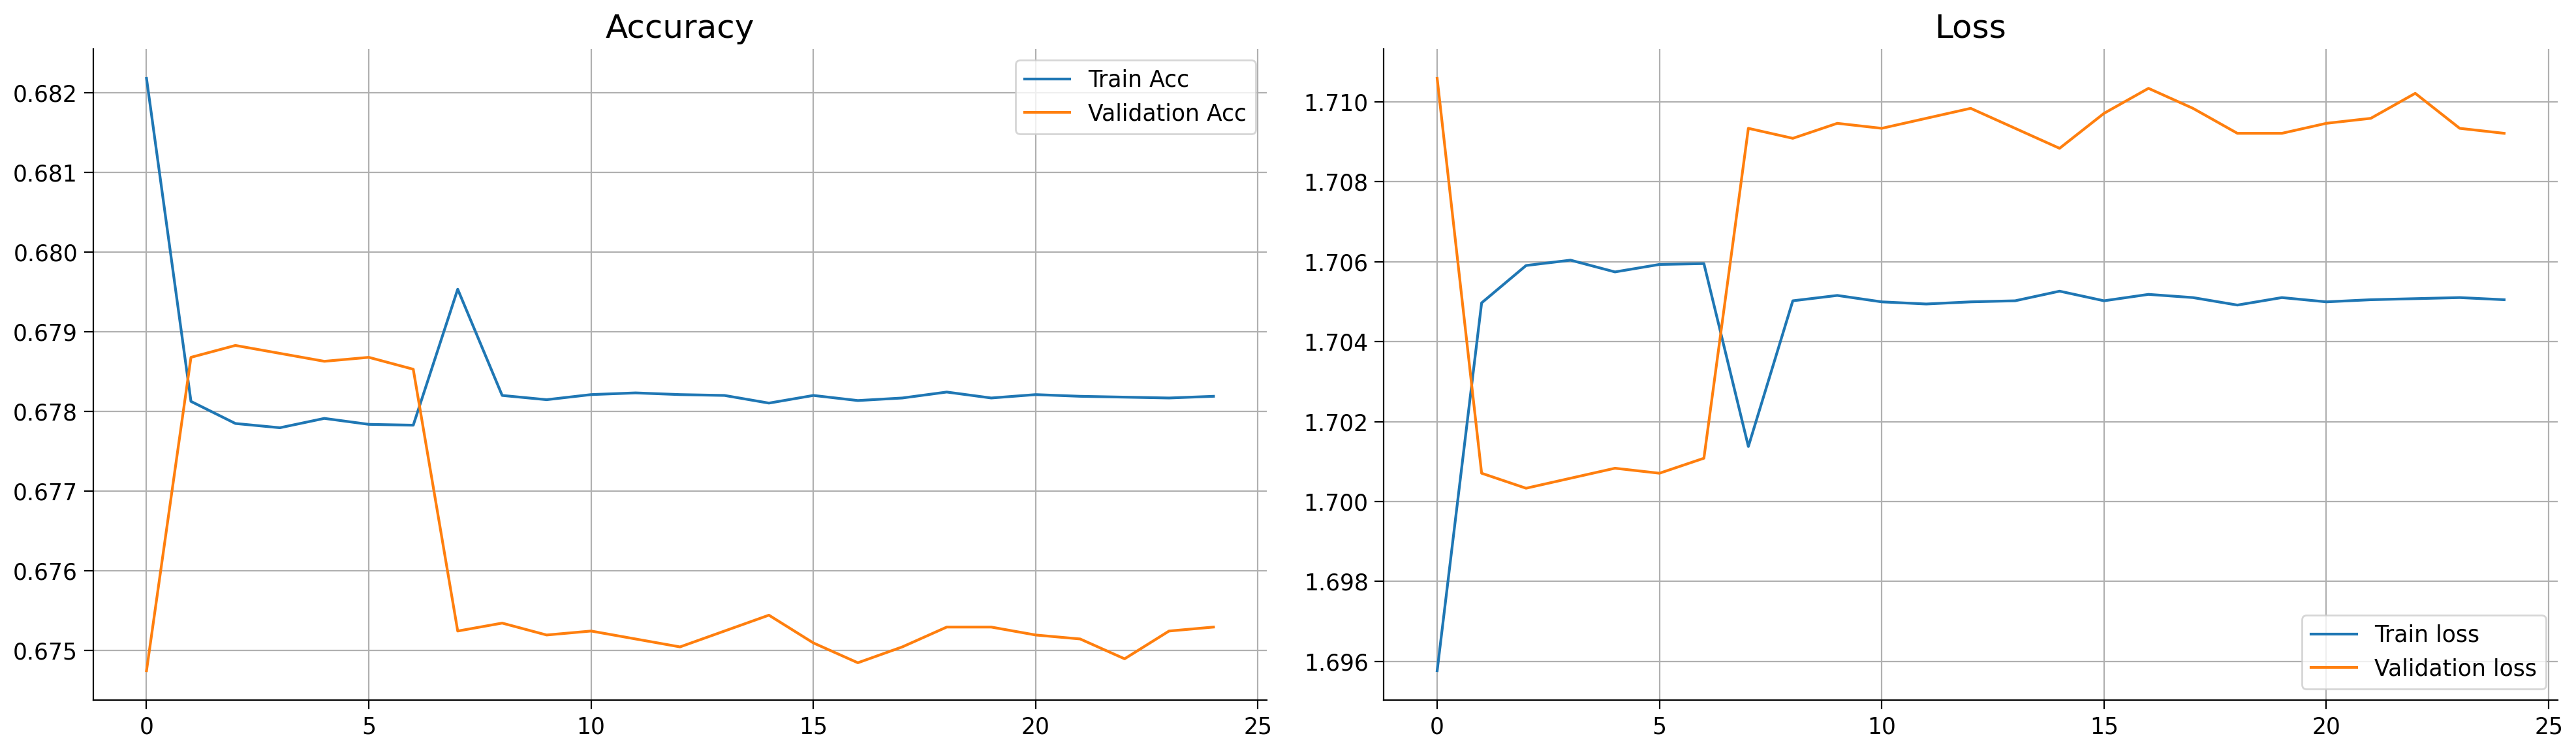

In [ ]:
# @title Plotting the Accuracy
fig = plt.figure(figsize = (20, 6))
plt.subplot(1, 2, 1)
plt.plot(epoch_tr_acc, label='Train Acc')
plt.plot(epoch_vl_acc, label='Validation Acc')
plt.title("Accuracy")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(epoch_tr_loss, label='Train loss')
plt.plot(epoch_vl_loss, label='Validation loss')
plt.title("Loss")
plt.legend()
plt.grid()

plt.show()

In [ ]:
# @title Evaluation of Model with Test_loader

test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size, drop_last=True)

predicted_outputs = []
true_labels = []

model.eval()

for inputs, labels in test_loader:
    # Initialize hidden state
    val_h = model.init_hidden(batch_size)
    val_h = tuple([each.data.to(device) for each in val_h])

    # Move batch inputs and labels to gpu
    inputs, labels = inputs.to(device), labels.to(device)

    # Compute model output
    output, val_h = model(inputs, val_h)

    predicted_outputs.append(output.detach().cpu().numpy())
    true_labels.append(labels.detach().cpu().numpy())

# Concatenate the arrays in the list to form a single array for true_labels and predicted_outputs
true_labels = np.concatenate(true_labels, axis=0)
predicted_outputs = np.concatenate(predicted_outputs, axis=0)

In [ ]:
# @title Evaluation Metrics

from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, classification_report
# Convert true_labels from one-hot to class indexes
# true_labels = np.argmax(true_labels, axis=1)
if true_labels.ndim > 1:
    true_labels = np.argmax(true_labels, axis=1)

# Convert predicted_outputs from probabilities to class indexes
predicted_classes  = np.argmax(predicted_outputs, axis=1)
print(len(predicted_classes))
print(len(true_labels))

precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predicted_classes, average='weighted', zero_division=0)
conf_matrix = confusion_matrix(true_labels, predicted_classes)

print("Precision (Weighted):", precision)
print("Recall (Weighted):", recall)
print("F1 Score (Weighted):", f1)
print("Confusion Matrix:\n", conf_matrix)
print(classification_report(true_labels, predicted_classes))

8000
8000
Precision (Weighted): 0.042281640625
Recall (Weighted): 0.205625
F1 Score (Weighted): 0.07014061689994816
Confusion Matrix:
 [[   0    0 1563    0    0]
 [   0    0 1638    0    0]
 [   0    0 1645    0    0]
 [   0    0 1606    0    0]
 [   0    0 1548    0    0]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1563
           1       0.00      0.00      0.00      1638
           2       0.21      1.00      0.34      1645
           3       0.00      0.00      0.00      1606
           4       0.00      0.00      0.00      1548

    accuracy                           0.21      8000
   macro avg       0.04      0.20      0.07      8000
weighted avg       0.04      0.21      0.07      8000




# Implementing The Model With GloVe

In [ ]:
# @title Defining the RNN Class
class SentimentRNN(nn.Module):
  def __init__(self,no_layers,vocab_size,hidden_dim,embedding_dim,drop_prob=0.1):
    super(SentimentRNN,self).__init__()

    self.output_dim = output_dim
    self.hidden_dim = hidden_dim
    self.no_layers = no_layers
    self.vocab_size = vocab_size
    self.drop_prob = drop_prob

    # Embedding Layer
    self.embedding = nn.Embedding(vocab_size, embedding_dim)
    self.embedding.weight = nn.Parameter(torch.tensor(glove_matrix, dtype=torch.float32))
    self.embedding.weight.requires_grad = False  # keeps embeddings fixed

    # LSTM Layers
    self.lstm = nn.LSTM(input_size=embedding_dim,hidden_size=self.hidden_dim,
                        num_layers=no_layers, batch_first=True,
                        dropout=self.drop_prob)

    # Dropout layer
    self.dropout = nn.Dropout(drop_prob)

    # Linear and Softmax layer
    self.fc = nn.Linear(self.hidden_dim, output_dim)
    self.softmax = nn.Softmax()

  def forward(self,x,hidden):
    batch_size = x.size(0)

    # Embedding out
    embeds = self.embedding(x)
    #Shape: [batch_size x max_length x embedding_dim]

    # LSTM out
    lstm_out, hidden = self.lstm(embeds, hidden)
    # Shape: [batch_size x max_length x hidden_dim]

    # Select the activation of the last Hidden Layer
    lstm_out = lstm_out[:,-1,:].contiguous()
    # Shape: [batch_size x hidden_dim]

    ## You can instead average the activations across all the times
    # lstm_out = torch.mean(lstm_out, 1).contiguous()

    # Dropout and Fully connected layer
    out = self.dropout(lstm_out)
    out = self.fc(out)

    # Sigmoid function
    sig_out = self.softmax(out)

    # return last sigmoid output and hidden state
    return sig_out, hidden

  def init_hidden(self, batch_size):
    ''' Initializes hidden state '''
    # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
    # initialized to zero, for hidden state and cell state of LSTM
    h0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
    c0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
    hidden = (h0,c0)
    return hidden

In [ ]:
# @title Network Parameters
# Size of our vocabulary
vocab_size = len(word_to_idx)

# Embedding dimension
embedding_dim = 100

# Number of stacked LSTM layers
no_layers = 2

# Dimension of the hidden layer in LSTMs
hidden_dim = 64

# Dropout parameter for regularization
output_dim = 5

# Dropout parameter for regularization
drop_prob = 0.25

In [ ]:
# @title Defining the Network
model = SentimentRNN(no_layers, vocab_size, hidden_dim,
                     embedding_dim, drop_prob=drop_prob)
# Moving to gpu
model.to(device)
print(model)

SentimentRNN(
  (embedding): Embedding(22852, 100)
  (lstm): LSTM(100, 64, num_layers=2, batch_first=True, dropout=0.25)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc): Linear(in_features=64, out_features=5, bias=True)
  (softmax): Softmax(dim=None)
)


In [ ]:
# @title Trainable Parameters
# How many trainable parameters does our model have?
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print('Total Number of parameters: ',params)

Total Number of parameters:  76101


In [ ]:
# @title Optimizing the Model Features
# loss and optimization functions
lr = 0.1

# Weighted crossentropy is a good loss function
criterion = nn.CrossEntropyLoss()

# We choose an Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# function to predict accuracy
def acc(pred,label):
  pred = torch.round(pred.squeeze())
  return torch.sum(pred == label.squeeze()).item()/5

In [ ]:
# @title Training the Model
# Number of training Epochs
epochs = 25

# Maximum absolute value accepted for the gradeint
clip = 1

# Initial Loss value (assumed big)
valid_loss_min = np.inf

# Lists to follow the evolution of the loss and accuracy
epoch_tr_loss, epoch_vl_loss = [], []
epoch_tr_acc, epoch_vl_acc = [], []

# Train for a number of Epochs
for epoch in range(epochs):
    train_losses = []
    train_acc = 0.0
    model.train()

    for inputs, labels in tqdm(train_loader, desc=f"Training Epoch {epoch+1}"):
        # Initialize hidden state
        h = model.init_hidden(batch_size)
        # Creating new variables for the hidden state
        h = tuple([each.data.to(device) for each in h])

        # Move batch inputs and labels to gpu
        inputs, labels = inputs.to(device), labels.to(device)

        # Set gradient to zero
        model.zero_grad()

        # Compute model output
        output, h = model(inputs, h)

        # Calculate the loss and perform backprop
        #print(output.squeeze())
        # print(labels.float())
        # print(output.squeeze)

        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        train_losses.append(loss.item())

        # calculating accuracy
        accuracy = acc(output, labels)
        train_acc += accuracy

        #`clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

    # Evaluate on the validation set for this epoch
    val_losses = []
    val_acc = 0.0
    model.eval()
    for inputs, labels in tqdm(valid_loader, desc=f"Validation Epoch {epoch+1}"):
        # Initialize hidden state
        val_h = model.init_hidden(batch_size)
        val_h = tuple([each.data.to(device) for each in val_h])

        # Move batch inputs and labels to gpu
        inputs, labels = inputs.to(device), labels.to(device)

        # Compute model output
        output, val_h = model(inputs, val_h)

        # Compute Loss
        val_loss = criterion(output.squeeze(), labels.float())

        val_losses.append(val_loss.item())

        accuracy = acc(output, labels)
        val_acc += accuracy

    epoch_train_loss = np.mean(train_losses)
    epoch_val_loss = np.mean(val_losses)
    epoch_train_acc = train_acc / len(train_loader.dataset)
    epoch_val_acc = val_acc / len(valid_loader.dataset)
    epoch_tr_loss.append(epoch_train_loss)
    epoch_vl_loss.append(epoch_val_loss)
    epoch_tr_acc.append(epoch_train_acc)
    epoch_vl_acc.append(epoch_val_acc)
    print(f'Epoch {epoch+1}')
    print(f'train_loss : {epoch_train_loss} val_loss : {epoch_val_loss}')
    print(f'train_accuracy : {epoch_train_acc*100} val_accuracy : {epoch_val_acc*100}')
    if epoch_val_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min, epoch_val_loss))
        # torch.save(model.state_dict(), '../working/state_dict.pt')
        valid_loss_min = epoch_val_loss
    print(25*'==')

Training Epoch 1:   0%|          | 0/374 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Validation Epoch 1: 100%|██████████| 80/80 [00:00<00:00, 225.15it/s]


Epoch 1
train_loss : 1.6524690485255604 val_loss : 1.6457984507083894
train_accuracy : 69.72556340845448 val_accuracy : 67.49471064094584
Validation loss decreased (inf --> 1.645798).  Saving model ...


Validation Epoch 2: 100%|██████████| 80/80 [00:00<00:00, 110.25it/s]


Epoch 2
train_loss : 1.6666195309735874 val_loss : 1.6462824925780297
train_accuracy : 67.96212828377121 val_accuracy : 67.51462352209087


Validation Epoch 3: 100%|██████████| 80/80 [00:00<00:00, 344.56it/s]


Epoch 3
train_loss : 1.696594759423465 val_loss : 1.7086970180273056
train_accuracy : 67.95039338578476 val_accuracy : 67.50964530180458


Validation Epoch 4: 100%|██████████| 80/80 [00:00<00:00, 365.14it/s]


Epoch 4
train_loss : 1.698791165084125 val_loss : 1.7098324373364449
train_accuracy : 67.85651420189359 val_accuracy : 67.50466708151835


Validation Epoch 5: 100%|██████████| 80/80 [00:00<00:00, 374.19it/s]


Epoch 5
train_loss : 1.7025861609428323 val_loss : 1.7098324447870255
train_accuracy : 67.91732230964134 val_accuracy : 67.50466708151836


Validation Epoch 6: 100%|██████████| 80/80 [00:00<00:00, 362.53it/s]


Epoch 6
train_loss : 1.7028537602985607 val_loss : 1.71008243560791
train_accuracy : 67.90665422056276 val_accuracy : 67.49471064094588


Validation Epoch 7: 100%|██████████| 80/80 [00:00<00:00, 304.09it/s]


Epoch 7
train_loss : 1.7026930970941636 val_loss : 1.7102074518799781
train_accuracy : 67.9130550740098 val_accuracy : 67.48973242065959


Validation Epoch 8: 100%|██████████| 80/80 [00:00<00:00, 371.94it/s]


Epoch 8
train_loss : 1.7025058244001419 val_loss : 1.709707447886467
train_accuracy : 67.92052273636483 val_accuracy : 67.50964530180462


Validation Epoch 9: 100%|██████████| 80/80 [00:00<00:00, 364.40it/s]


Epoch 9
train_loss : 1.7026127455706266 val_loss : 1.7100824400782586
train_accuracy : 67.9162555007334 val_accuracy : 67.49471064094584


Validation Epoch 10: 100%|██████████| 80/80 [00:00<00:00, 360.85it/s]


Epoch 10
train_loss : 1.7028532305503274 val_loss : 1.7103324472904204
train_accuracy : 67.90665422056271 val_accuracy : 67.48475420037337


Validation Epoch 11: 100%|██████████| 80/80 [00:00<00:00, 371.54it/s]


Epoch 11
train_loss : 1.7026130047073975 val_loss : 1.7098324403166771
train_accuracy : 67.91625550073348 val_accuracy : 67.50466708151833


Validation Epoch 12: 100%|██████████| 80/80 [00:00<00:00, 300.67it/s]


Epoch 12
train_loss : 1.7028265764369046 val_loss : 1.7103324383497238
train_accuracy : 67.9077210294706 val_accuracy : 67.48475420037336


Validation Epoch 13: 100%|██████████| 80/80 [00:00<00:00, 354.14it/s]


Epoch 13
train_loss : 1.702746132478357 val_loss : 1.709582443535328
train_accuracy : 67.91092145619413 val_accuracy : 67.51462352209082


Validation Epoch 14: 100%|██████████| 80/80 [00:00<00:00, 364.79it/s]


Epoch 14
train_loss : 1.7028528139552968 val_loss : 1.7102074399590492
train_accuracy : 67.90665422056273 val_accuracy : 67.48973242065962


Validation Epoch 15: 100%|██████████| 80/80 [00:00<00:00, 376.37it/s]


Epoch 15
train_loss : 1.7027911664967867 val_loss : 1.682246857881546
train_accuracy : 67.90132017602352 val_accuracy : 67.49968886123212


Validation Epoch 16: 100%|██████████| 80/80 [00:00<00:00, 369.04it/s]


Epoch 16
train_loss : 1.7048200556938662 val_loss : 1.7098324343562126
train_accuracy : 67.80210694759307 val_accuracy : 67.50466708151835


Validation Epoch 17: 100%|██████████| 80/80 [00:00<00:00, 292.65it/s]


Epoch 17
train_loss : 1.705260252570086 val_loss : 1.7095824494957923
train_accuracy : 67.81064141885588 val_accuracy : 67.51462352209086


Validation Epoch 18: 100%|██████████| 80/80 [00:00<00:00, 379.60it/s]


Epoch 18
train_loss : 1.7050730844232487 val_loss : 1.7098324418067932
train_accuracy : 67.8181090812108 val_accuracy : 67.50466708151835


Validation Epoch 19: 100%|██████████| 80/80 [00:00<00:00, 361.05it/s]


Epoch 19
train_loss : 1.7050730882481457 val_loss : 1.7097074404358863
train_accuracy : 67.81810908121084 val_accuracy : 67.5096453018046


Validation Epoch 20: 100%|██████████| 80/80 [00:00<00:00, 373.96it/s]


Epoch 20
train_loss : 1.7050196123633155 val_loss : 1.7094574496150017
train_accuracy : 67.82024269902654 val_accuracy : 67.5196017423771


Validation Epoch 21: 100%|██████████| 80/80 [00:00<00:00, 371.01it/s]


Epoch 21
train_loss : 1.7048859146827045 val_loss : 1.7093324288725853
train_accuracy : 67.82557674356586 val_accuracy : 67.52457996266334


Validation Epoch 22: 100%|██████████| 80/80 [00:00<00:00, 297.89it/s]


Epoch 22
train_loss : 1.7052335098465496 val_loss : 1.7095824375748634
train_accuracy : 67.81170822776362 val_accuracy : 67.51462352209084


Validation Epoch 23: 100%|██████████| 80/80 [00:00<00:00, 356.27it/s]


Epoch 23
train_loss : 1.7050998166283184 val_loss : 1.709582433104515
train_accuracy : 67.81704227230296 val_accuracy : 67.51462352209084


Validation Epoch 24: 100%|██████████| 80/80 [00:00<00:00, 355.59it/s]


Epoch 24
train_loss : 1.7049928693210377 val_loss : 1.7097074374556542
train_accuracy : 67.8213095079344 val_accuracy : 67.5096453018046


Validation Epoch 25: 100%|██████████| 80/80 [00:00<00:00, 373.69it/s]

Epoch 25
train_loss : 1.7049393959861388 val_loss : 1.7098324328660965
train_accuracy : 67.8234431257501 val_accuracy : 67.50466708151836


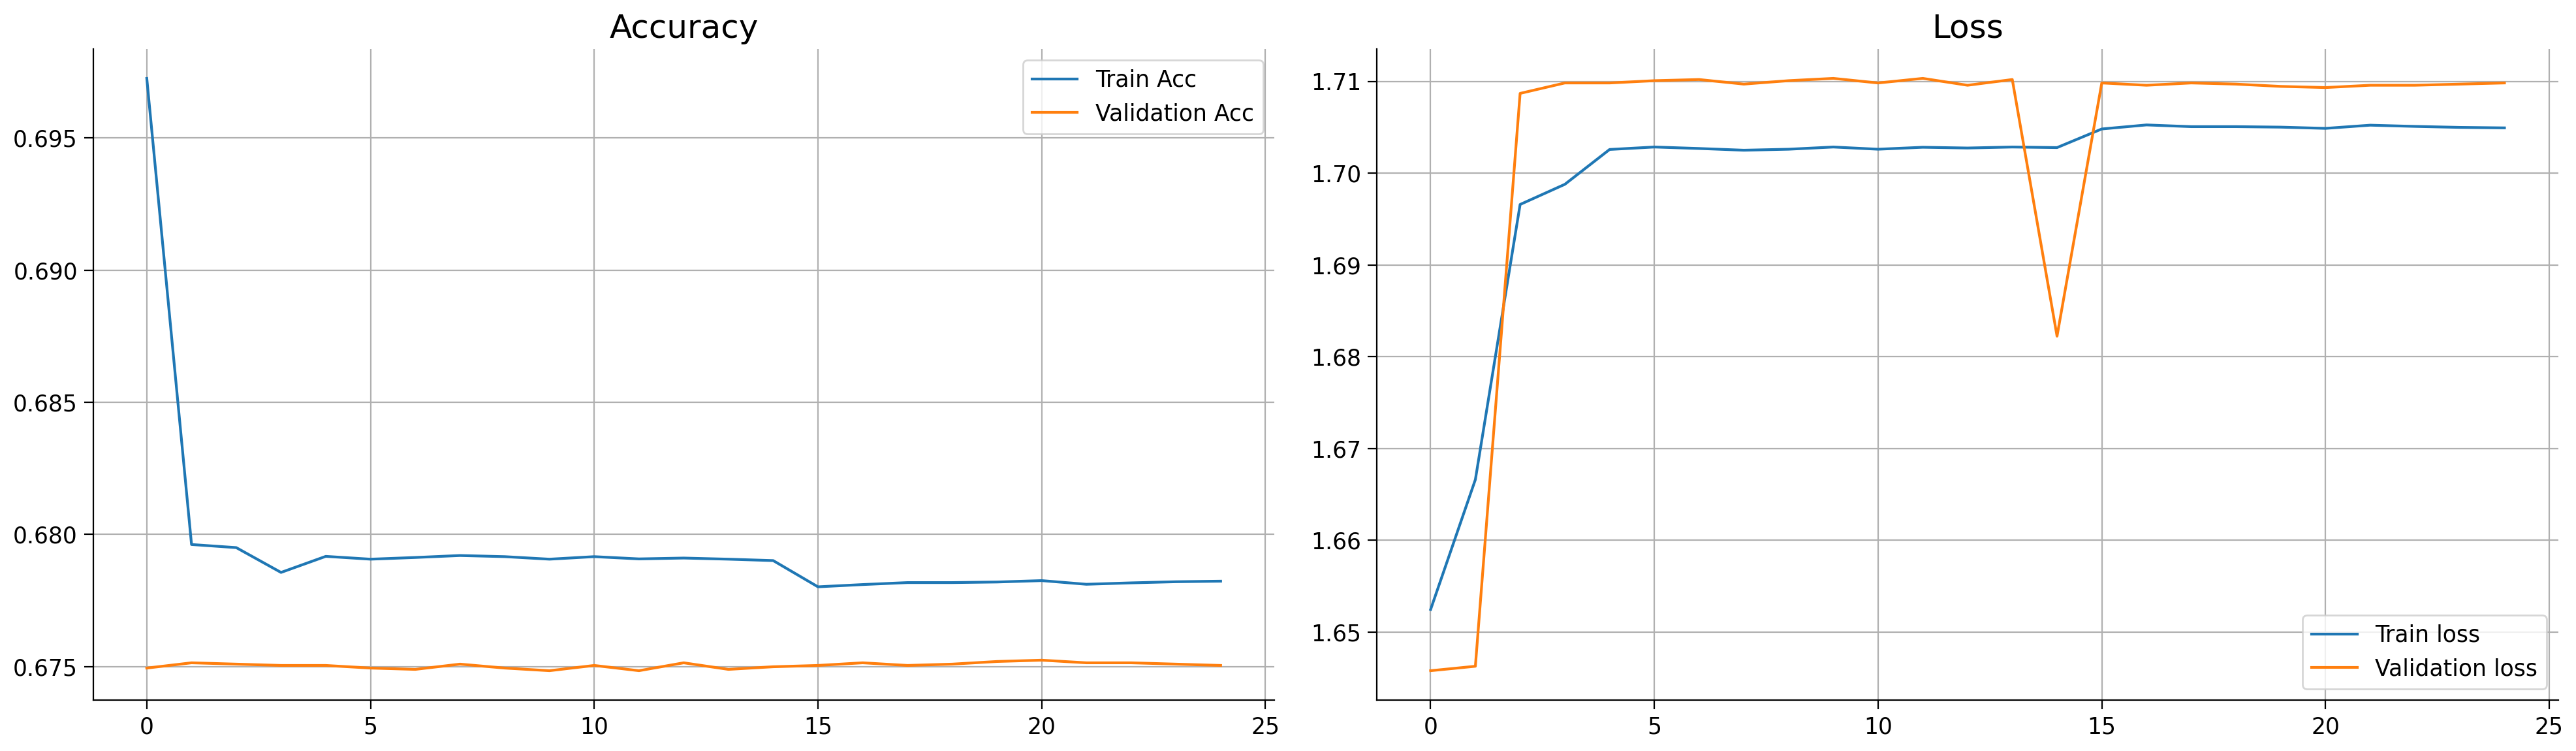

In [ ]:
# @title Plotting the Accuracy
fig = plt.figure(figsize = (20, 6))
plt.subplot(1, 2, 1)
plt.plot(epoch_tr_acc, label='Train Acc')
plt.plot(epoch_vl_acc, label='Validation Acc')
plt.title("Accuracy")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(epoch_tr_loss, label='Train loss')
plt.plot(epoch_vl_loss, label='Validation loss')
plt.title("Loss")
plt.legend()
plt.grid()

plt.show()

In [ ]:
# @title Evaluation of Model with Test_loader

test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size, drop_last=True)

predicted_outputs = []
true_labels = []

model.eval()

for inputs, labels in test_loader:
    # Initialize hidden state
    val_h = model.init_hidden(batch_size)
    val_h = tuple([each.data.to(device) for each in val_h])

    # Move batch inputs and labels to gpu
    inputs, labels = inputs.to(device), labels.to(device)

    # Compute model output
    output, val_h = model(inputs, val_h)

    predicted_outputs.append(output.detach().cpu().numpy())
    true_labels.append(labels.detach().cpu().numpy())

# Concatenate the arrays in the list to form a single array for true_labels and predicted_outputs
true_labels = np.concatenate(true_labels, axis=0)
predicted_outputs = np.concatenate(predicted_outputs, axis=0)

In [ ]:
# @title Evaluation Metrics

from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, classification_report
# Convert true_labels from one-hot to class indexes
# true_labels = np.argmax(true_labels, axis=1)
if true_labels.ndim > 1:
    true_labels = np.argmax(true_labels, axis=1)

# Convert predicted_outputs from probabilities to class indexes
predicted_classes  = np.argmax(predicted_outputs, axis=1)

precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predicted_classes , average='weighted')
conf_matrix = confusion_matrix(true_labels, predicted_classes )

print("Precision (Weighted):", precision)
print("Recall (Weighted):", recall)
print("F1 Score (Weighted):", f1)
print("Confusion Matrix:\n", conf_matrix)
print(classification_report(true_labels, predicted_classes))

Precision (Weighted): 0.042281640625
Recall (Weighted): 0.205625
F1 Score (Weighted): 0.07014061689994816
Confusion Matrix:
 [[   0    0 1563    0    0]
 [   0    0 1638    0    0]
 [   0    0 1645    0    0]
 [   0    0 1606    0    0]
 [   0    0 1548    0    0]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1563
           1       0.00      0.00      0.00      1638
           2       0.21      1.00      0.34      1645
           3       0.00      0.00      0.00      1606
           4       0.00      0.00      0.00      1548

    accuracy                           0.21      8000
   macro avg       0.04      0.20      0.07      8000
weighted avg       0.04      0.21      0.07      8000



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif